In [1]:
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import torchtext.data as data
from datetime import datetime
import spacy
from spacy.symbols import ORTH, LEMMA, POS, TAG
import re
import matplotlib.pyplot as plt
from bleu import moses_multi_bleu
%matplotlib inline

/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
torch.manual_seed(42)

In [4]:
NLP = spacy.load('en')

def tokenizer(s):
    s = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(s))
    s = re.sub(r"[ ]+", " ", s)
    s = re.sub(r"\!+", "!", s)
    s = re.sub(r"\,+", ",", s)
    s = re.sub(r"\?+", "?", s)
    if (s.startswith("'") and s.endswith("'")) or (s.startswith('"') and s.endswith('"')):
        s = s[1:-1]
    MAX_CHARS = 20_000
    if (len(s) > MAX_CHARS):
        s = s[:MAX_CHARS]
        
    special_case = [{ORTH: '<nl>'}]
    NLP.tokenizer.add_special_case('<nl>', special_case)
    return [x.text for x in NLP.tokenizer(s) if x.text != " "]

/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cephfs/home/seliverstov/oml2/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [5]:
TEXT = torchtext.data.Field(eos_token='<eos>', 
                            init_token='<sos>', 
                            tokenize=tokenizer, 
                            lower=True)
LABEL = torchtext.data.Field(sequential=False, unk_token=None)

In [6]:
class Multi30KEminem(torchtext.data.Dataset):

    urls = ['http://files.deeppavlov.ai/datasets/multi30k_eminem.zip']
    name = 'multi30k_eminem'
    dirname = ''

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    def __init__(self, path, text_field, label_field, **kwargs):
       
        fields = [('text', text_field), ('label', label_field)]
        examples = []

        with open(path) as f:
            for line in f.readlines():
                line = line.strip()
                label = line[-1]
                text = line[:-2]
                examples.append(data.Example.fromlist([text, label], fields))
        
        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='multi30k_eminem.train.txt', 
               validation='multi30k_eminem.valid.txt', 
               test='multi30k_eminem.test.txt', **kwargs):
        
        return super().splits(
            root=root, text_field=text_field, label_field=label_field,
            train=train, validation=validation, test=test, **kwargs)

    @classmethod
    def iters(cls, batch_size=32, device=0, root='.data', vectors=None, **kwargs):
        
        TEXT = data.Field()
        LABEL = data.Field(sequential=False)

        train, valid, test = cls.splits(TEXT, LABEL, root=root, **kwargs)

        TEXT.build_vocab(train, vectors=vectors)
        LABEL.build_vocab(train)

        return data.BucketIterator.splits(
            (train, test), batch_size=batch_size, device=device)


In [7]:
Multi30KEminem.download('.')

'./multi30k_eminem/'

In [8]:
train_ds, valid_ds, _ = Multi30KEminem.splits(TEXT, LABEL, '.')
len(train_ds), len(valid_ds)

(58000, 2000)

In [9]:
TEXT.build_vocab(train_ds)
LABEL.build_vocab(train_ds)
len(TEXT.vocab) , len(LABEL.vocab)

(17670, 2)

In [10]:
LABEL.vocab.itos[0], LABEL.vocab.itos[1]

('0', '1')

In [11]:
batch_size = 128

In [12]:
train_dl = torchtext.data.Iterator(train_ds, batch_size, repeat=False, shuffle=False)
valid_dl = torchtext.data.Iterator(valid_ds, batch_size, repeat=False)
gen_dl = torchtext.data.Iterator(train_ds, 1, repeat=False)

In [13]:
vocab_size = len(TEXT.vocab)

In [14]:
TEXT.vocab.load_vectors('fasttext.en.300d')

In [15]:
def to_onehot(data, n_digits):
    y = torch.zeros(data.shape[0], n_digits).cuda().scatter(1,data[:,None],1)
    return y

In [16]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers, lr = 1e-4, dropout=0.0, vectors = None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if vectors is not None:
            self.emb.weight.data.copy_(vectors)
            self.emb.weight.data.requires_grad = False
            
        self.rnn = nn.LSTM(emb_size, hidden_size, n_layers, dropout=dropout, bidirectional = True)
        
        self.optim = self.optim = torch.optim.Adam(self.learnable_parameters(), lr)
        
        
    def forward(self, x, hidden = None):
        x = self.emb(x)
        o, (h, c) = self.rnn(x, hidden)
        
        (_, batch_size, hidden_size) = c.shape # [2*n_layers, batch_size, hidden_size]
        c = c.view(-1, 2, batch_size, hidden_size) # [n_layers, 2, batch_size, hidden_size] 
        c = c[-1] # take only last layer
        c = torch.cat((c[0], c[1]), 1) # concatenate ontput from both directions to single vector
        
        return c
    
    def learnable_parameters(self):
        return [p for p in self.parameters() if p.requires_grad]

In [17]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, prior_size, n_layers, dropout=0.0, lr = 1e-4, vectors = None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if vectors is not None:
            self.emb.weight.data.copy_(vectors)
            self.emb.weight.data.requires_grad = False
        
        self.rnn = nn.LSTM(emb_size + prior_size, hidden_size, n_layers, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.optim = self.optim = torch.optim.Adam(self.learnable_parameters(), lr)
        
    def forward(self, x, z, hidden = None, y = None):
        x = self.emb(x)
        
        (seq_len, batch_size, emb_size) = x.shape
        z = z[None, :, :]
        z = z.repeat(seq_len, 1, 1)
        x = torch.cat((x, z), 2)
        
        if y is not None:
            y = y[None, :, :]
            y = y.repeat(seq_len, 1, 1)
            x = torch.cat([x, y], dim=2)
        
        o, (h, c) = self.rnn(x, hidden)
        
        (seq_len, batch_size, hidden_size) = o.shape
        
        x = o.view(-1, hidden_size)
        x = F.log_softmax(self.fc(x), dim=1)
        return x, (h, c)
    
    def learnable_parameters(self):
        return [p for p in self.parameters() if p.requires_grad]

In [18]:
class Discriminator(nn.Module):
    def __init__(self, sizes, dropout=False, lr=1e-4, bn=False, activation_fn=nn.Tanh(), last_fn=None, first_fn=None):
        super().__init__()
        
        layers = []
        
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if bn:
                layers.append(nn.BatchNorm1d(sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
        self.optim = torch.optim.Adam(self.parameters(), lr)
        
    def forward(self, x, y=None):
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [19]:
class SeqDiscriminator(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, prior_size, 
                 n_layers, dropout=0.0, lr = 1e-4, vectors = None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)
        if vectors is not None:
            self.emb.weight.data.copy_(vectors)
            self.emb.weight.data.requires_grad = False
        
        self.rnn = nn.LSTM(emb_size + prior_size, hidden_size, n_layers, dropout=dropout)
       
        self.head = nn.Linear(hidden_size, 1)
        
        self.optim = self.optim = torch.optim.Adam(self.learnable_parameters(), lr)
        
    def forward(self, x, y, logits = False, hidden=None):
        if not logits:
            x = self.emb(x)
        else:
            x = torch.matmul(x, self.emb.weight)
            x = x.permute(1,0,2)
        
        (seq_len, batch_size, emb_size) = x.shape
        
        if y is not None:
            y = y[None, :, :]
            y = y.repeat(seq_len, 1, 1)
            x = torch.cat([x, y], dim=2)
        
        o, h = self.rnn(x, hidden)

        (seq_len, batch_size, hidden_size) = o.shape
        
        x = o[-1].view(-1, hidden_size)
        x = self.head(x)
        return x
    
    def learnable_parameters(self):
        return [p for p in self.parameters() if p.requires_grad]

In [20]:
def seq_to_str(seq):
    (seq_len, batch_size) = seq.shape
    result = []
    for i in range(batch_size):
        result.append(" ".join([TEXT.vocab.itos[w_idx.item()] for w_idx in seq[:,i].view(-1)]))
    return result

In [21]:
def train_raae(epoch, enc, dec, disc, seq_disc, prior_size, train_dl):
    enc.train()
    dec.train()
    disc.train()
    seq_disc.train()
    
    train_g_loss = 0.0
    train_ae_loss = 0.0
    train_disc_loss = 0.0
    train_seq_disc_loss = 0.0
    
    strs = []
    dec_strs = []
    
    for batch_idx, batch in enumerate(train_dl):
       
        seq = batch.text
        seq = seq[1:]
        
        label = batch.label
        label = to_onehot(label, 2)
       
        (seq_len, batch_size) = seq.shape
        
        batch_zeros = torch.zeros((batch_size, 1)).cuda()
        batch_ones = torch.ones((batch_size, 1)).cuda()
        
        # ======== train ZDisc ========
        
        enc.zero_grad()
        disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).cuda()
        z_label = to_onehot(torch.tensor(np.random.randint(0, 2, (batch_size))).cuda(), 2).cuda()

        latent = enc(seq)
        fake_pred = disc(latent, label)
        true_pred = disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        disc_loss = 0.5*(fake_loss + true_loss)
        
        disc_loss.backward()
        disc.optim.step()
        
        
        # ======== train SeqDisc ========
        
        enc.zero_grad()
        dec.zero_grad()
        seq_disc.zero_grad()
                
        latent = enc(seq)
        
        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        (_, vocab_size) = output.shape
        output = output.view(batch_size, -1, vocab_size)
        
        fake_pred = seq_disc(output, label, logits=True)
        true_pred = seq_disc(seq, label, logits=False)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        seq_disc_loss = 0.5*(fake_loss + true_loss)
        
        seq_disc_loss.backward()
        seq_disc.optim.step()
        
        # ======== train AE ========
        enc.zero_grad()
        dec.zero_grad()
        disc.zero_grad()
        seq_disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        
        latent = enc(seq)
        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        
        
        _, w_idxs = output.topk(1, dim=1)
        dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        ae_loss = F.nll_loss(output, seq.view(-1))        
        
        fake_pred_z = disc(latent, label)
        
        enc_loss = F.binary_cross_entropy_with_logits(fake_pred_z, batch_ones)
        
        (_, vocab_size) = output.shape
        output = output.view(batch_size, -1, vocab_size)
        
        fake_pred_seq = seq_disc(output, label, logits=True)
        
        dec_loss = F.binary_cross_entropy_with_logits(fake_pred_seq, batch_ones)
        
        g_loss = ae_loss + enc_loss + dec_loss
        
        g_loss.backward()
        dec.optim.step()
        enc.optim.step()
        
        # ----------------------------------------------------
        
        train_g_loss += g_loss.item()
        train_ae_loss += ae_loss.item()
        train_disc_loss += disc_loss.item()
        train_seq_disc_loss += seq_disc_loss.item()
        
        
        #_, w_idxs = output.topk(1, dim=1)
        #dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        strs.extend(seq_to_str(seq.detach()))
        dec_strs.extend(seq_to_str(dec_seq.detach()))

    train_g_loss /= len(train_dl)
    train_ae_loss /= len(train_dl)
    train_disc_loss /= len(train_dl)
    train_seq_disc_loss /= len(train_dl)
    
    train_bleu = moses_multi_bleu(np.array(dec_strs), np.array(strs))
    
    print("Epoch {:3} {:5}: BLEU: {:.2f}, AE: {:.5f}, G: {:.5f}, ZD: {:.5f}, SeqD: {:.5f}  at {}".format(
        epoch, 'Train', train_bleu, train_ae_loss, train_g_loss, train_disc_loss, 
        train_seq_disc_loss, datetime.now().strftime("%H:%M:%S")))
    
    return train_ae_loss, train_g_loss, train_disc_loss, train_seq_disc_loss, train_bleu

In [22]:
def validate_raae(epoch, enc, dec, disc, seq_disc, prior_size, valid_dl, name):
    enc.eval()
    dec.eval()
    disc.eval()
    seq_disc.eval()
    
    valid_g_loss = 0.0
    valid_ae_loss = 0.0
    valid_disc_loss = 0.0
    valid_seq_disc_loss = 0.0
    
    strs = []
    dec_strs = []
    
    for batch_idx, batch in enumerate(valid_dl):
            
        seq = batch.text
        seq = seq[1:]
        
        label = batch.label
        label = to_onehot(label, 2)
       
        (seq_len, batch_size) = seq.shape
        
        # ======== valid Disc ========
        
        batch_zeros = torch.zeros((batch_size, 1)).cuda()
        batch_ones = torch.ones((batch_size, 1)).cuda()
        
        z = torch.randn((batch_size, prior_size)).cuda()
        z_label = to_onehot(torch.tensor(np.random.randint(0, 2, (batch_size))).cuda(), 2).cuda()
        
        fake_pred = disc(enc(seq), label)
        true_pred = disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        disc_loss = 0.5*(fake_loss + true_loss)
        
        # ======== valid SeqDisc ========

        latent = enc(seq)

        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        (_, vocab_size) = output.shape
        output = output.view(batch_size, -1, vocab_size)
        
        fake_pred = seq_disc(output, label, logits=True)
        true_pred = seq_disc(seq, label, logits=False)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        seq_disc_loss = 0.5*(fake_loss + true_loss)
        
        
        # ======== valid AE ========
        
        z = torch.randn((batch_size, prior_size))
        
        latent = enc(seq)
        x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
        
        h = None
        
        output = None
        
        for i in range(seq_len):
            o, h = dec(x, latent, h, label)
            x = seq[i].view(1, -1)
            output = o if output is None else torch.cat((output, o), 0)
        
        _, w_idxs = output.topk(1, dim=1)
        dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        ae_loss = F.nll_loss(output, seq.view(-1))        
        
        fake_pred_z = disc(latent,label)
        
        enc_loss = F.binary_cross_entropy_with_logits(fake_pred_z, batch_ones)
        
        (_, vocab_size) = output.shape
        output = output.view(batch_size, -1, vocab_size)
        
        fake_pred_seq = seq_disc(output, label, logits=True)
        
        dec_loss = F.binary_cross_entropy_with_logits(fake_pred_seq, batch_ones)
        
        g_loss = ae_loss + enc_loss + dec_loss
        
        # ------------------------------------------------------------------
        
        valid_g_loss += g_loss.item()
        valid_ae_loss += ae_loss.item()
        valid_disc_loss += disc_loss.item()
        valid_seq_disc_loss += seq_disc_loss.item()
        
        #_, w_idxs = output.topk(1, dim=1)
        #dec_seq = torch.tensor(w_idxs.view(seq_len, batch_size))
        
        strs.extend(seq_to_str(seq.detach()))
        dec_strs.extend(seq_to_str(dec_seq.detach()))
        
    valid_g_loss /= len(valid_dl)
    valid_ae_loss /= len(valid_dl)
    valid_disc_loss /= len(valid_dl)
    valid_seq_disc_loss /= len(valid_dl)
    
    valid_bleu = moses_multi_bleu(np.array(dec_strs), np.array(strs))
    
    print("Epoch {:3} {:5}: BLEU: {:.2f}, AE: {:.5f}, G: {:.5f}, ZD: {:.5f}, SeqD: {:.5f}  at {}".format(
        epoch, name, valid_bleu, valid_ae_loss, valid_g_loss, valid_disc_loss, valid_seq_disc_loss, datetime.now().strftime("%H:%M:%S")))
    
    return valid_ae_loss, valid_g_loss, valid_disc_loss, valid_seq_disc_loss, valid_bleu

In [23]:
def decode_z(dec, z, seq_len, label):
    dec.eval()
    
    (batch_size, hidden_size) = z.shape
    
    label = to_onehot(label, 2)
    
    x = torch.zeros(1,batch_size).long().cuda() + TEXT.vocab.stoi['<sos>']
    h = None
        
    dec_seq = None
    
    for i in range(seq_len):
        o, h = dec(x, z, h, label)
        _, w_idxs = o.topk(1)
        x = w_idxs.view(1, -1)
        dec_seq = w_idxs if dec_seq is None else torch.cat((dec_seq, w_idxs), 0)
        if batch_size == 1 and TEXT.vocab.itos[w_idxs.item()] == '<eos>':
            break
        
    return dec_seq

In [24]:
def print_decoded(enc, dec, dl):
    enc.eval()
    dec.eval()
    
    b = next(iter(dl))
    seq = b.text
    seq = seq[1:]
    
    label = b.label
    
    (seq_len, batch_size) = seq.shape
    
    z = enc(seq)
    
    dec_seq = decode_z(dec, z, seq_len, label)

    print("\nOrigin:  {}".format(seq_to_str(seq.detach())))
    print("Decoded: {}\n".format(seq_to_str(dec_seq.detach())))
    

In [25]:
def print_sample(dec, sample_size, max_seq_len):
    dec.eval()
    
    z = torch.randn(1, sample_size).cuda()
    print("\nRandom sample:")
    
    label_0 = torch.zeros(1).long().cuda()
    dec_seq = decode_z(dec, z, max_seq_len, label_0)
    print("\tdecoded w. style M: {}".format(seq_to_str(dec_seq.detach())))
    
    label_1 = (torch.zeros(1) + 1).long().cuda()
    dec_seq = decode_z(dec, z, max_seq_len, label_1)
    print("\tdecoded w. style E: {}\n".format(seq_to_str(dec_seq.detach())))

In [26]:
def plot_metrics(metrics, idx = 0, metric_name = 'Loss'):
    plt.figure(figsize=(20,10))
    for model, (trn, val, tst) in metrics.items():
        trn = [metric[idx] for metric in trn]
        val = [metric[idx] for metric in val]
        tst = [metric[idx] for metric in tst]
        if trn:
            plt.plot(trn, label=f'{model} Train')
        if val:
            plt.plot(val, label=f'{model} Valid', marker='v')
        if tst:
            plt.plot(tst, label=f'{model} Test', marker='o')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.show()

In [27]:
hidden_size = 500
prior_size = 2 * hidden_size
label_size = 2

In [28]:
Enc = Encoder(vocab_size, 300, hidden_size, n_layers=3, dropout=0.3, lr=1e-4, vectors=TEXT.vocab.vectors).cuda()
Dec = Decoder(vocab_size, 300, hidden_size, prior_size + label_size, n_layers=3, dropout=0.3, lr=1e-4, vectors=TEXT.vocab.vectors).cuda()
ZDisc = Discriminator([prior_size + label_size, hidden_size, 1], dropout=0.3, lr=1e-4, activation_fn=nn.LeakyReLU(0.2)).cuda()
SeqDisc = SeqDiscriminator(vocab_size, 300, 100, prior_size = label_size, n_layers=2, dropout=0.3, lr=1e-4, vectors=TEXT.vocab.vectors).cuda()

In [29]:
Enc

Encoder(
  (emb): Embedding(17670, 300)
  (rnn): LSTM(300, 500, num_layers=3, dropout=0.3, bidirectional=True)
)

In [30]:
Dec

Decoder(
  (emb): Embedding(17670, 300)
  (rnn): LSTM(1302, 500, num_layers=3, dropout=0.3)
  (fc): Linear(in_features=500, out_features=17670, bias=True)
)

In [31]:
ZDisc

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1002, out_features=500, bias=True)
    (1): Dropout(p=0.3)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [32]:
SeqDisc

SeqDiscriminator(
  (emb): Embedding(17670, 300)
  (rnn): LSTM(302, 100, num_layers=2, dropout=0.3)
  (head): Linear(in_features=100, out_features=1, bias=True)
)

In [33]:
metrics = {'CRAAE': ([], [], [])}

========== Start epoch 1 at 19:58:46 ==========
Epoch   1 Train: BLEU: 51.03, AE: 3.81728, G: 7.22129, ZD: 1.89258, SeqD: 0.14292  at 20:04:04
Epoch   1 Valid: BLEU: 52.74, AE: 2.98848, G: 8.04300, ZD: 1.86894, SeqD: 0.00567  at 20:04:10

Origin:  ['a young woman is walking through seated spectators . <eos>']
Decoded: ['a a a a a a a a a a']


Random sample:
	decoded w. style M: ['a a a a a a <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
	decoded w. style E: ['a a a a a a <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']

========== Start epoch 2 at 20:04:10 ==========
Epoch   2 Train: BLEU: 54.28, AE: 2.96174, G: 9.16237, ZD: 1.10395, SeqD: 0.00329  at 20:09:30
Epoch   2 Valid: BLEU: 56.48, AE: 2.75284, G: 9.54737, ZD: 0.87859, SeqD: 0.00185  at 20:09:36

Origin:  ['two women , one wearing pi

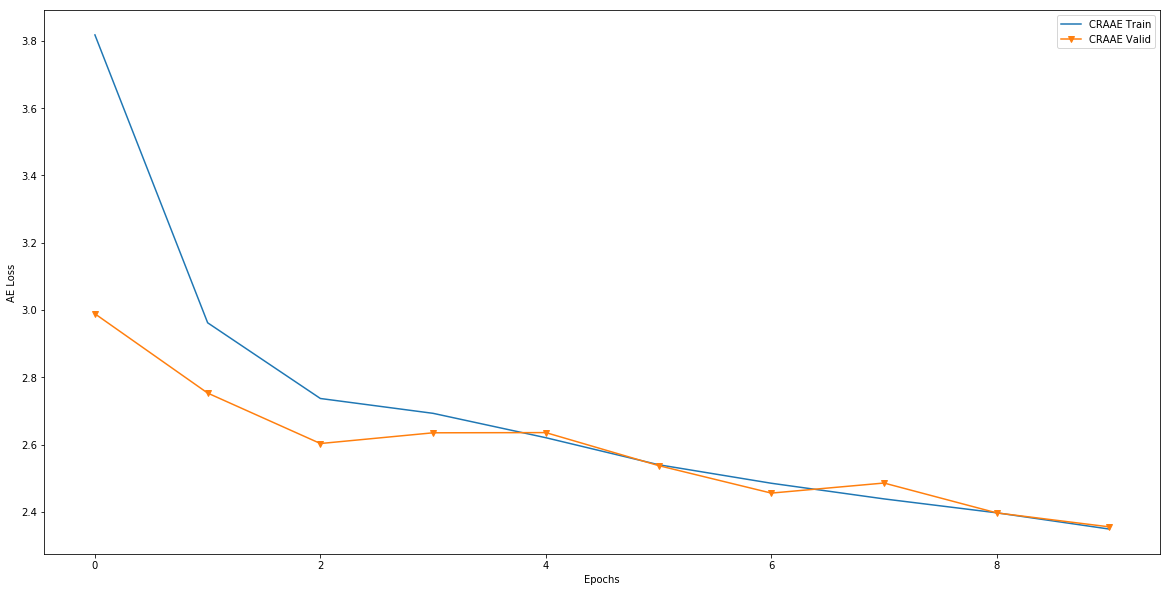

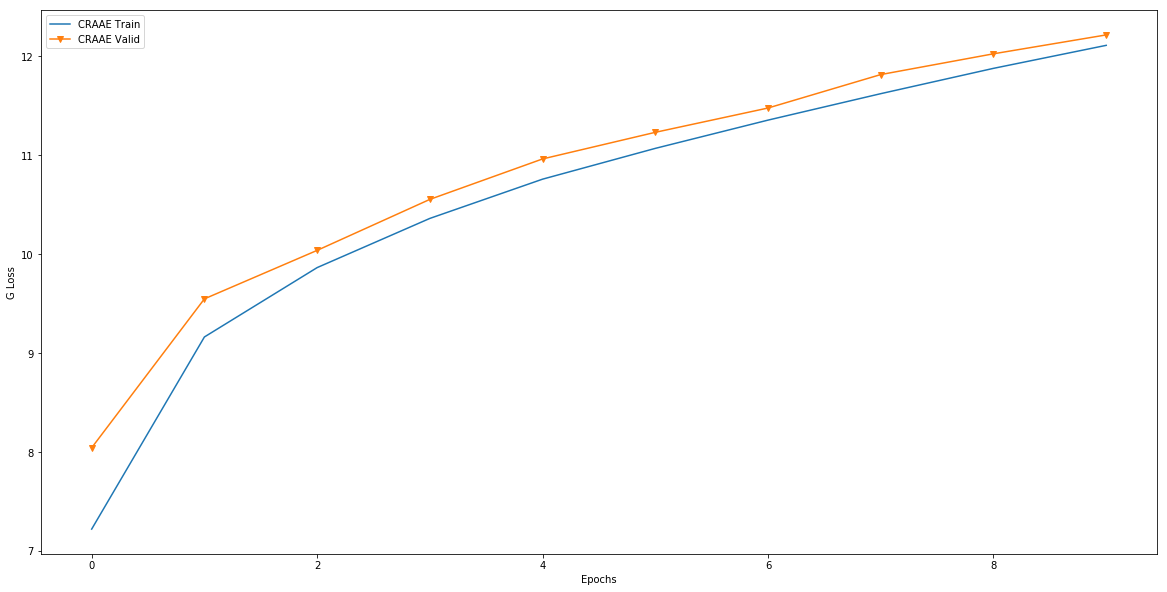

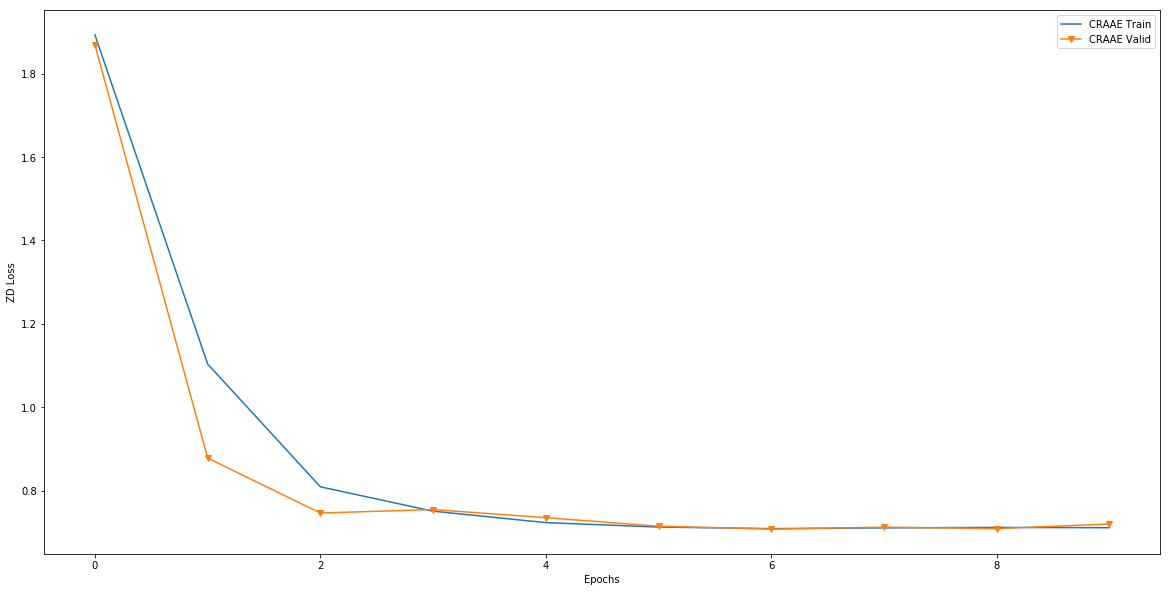

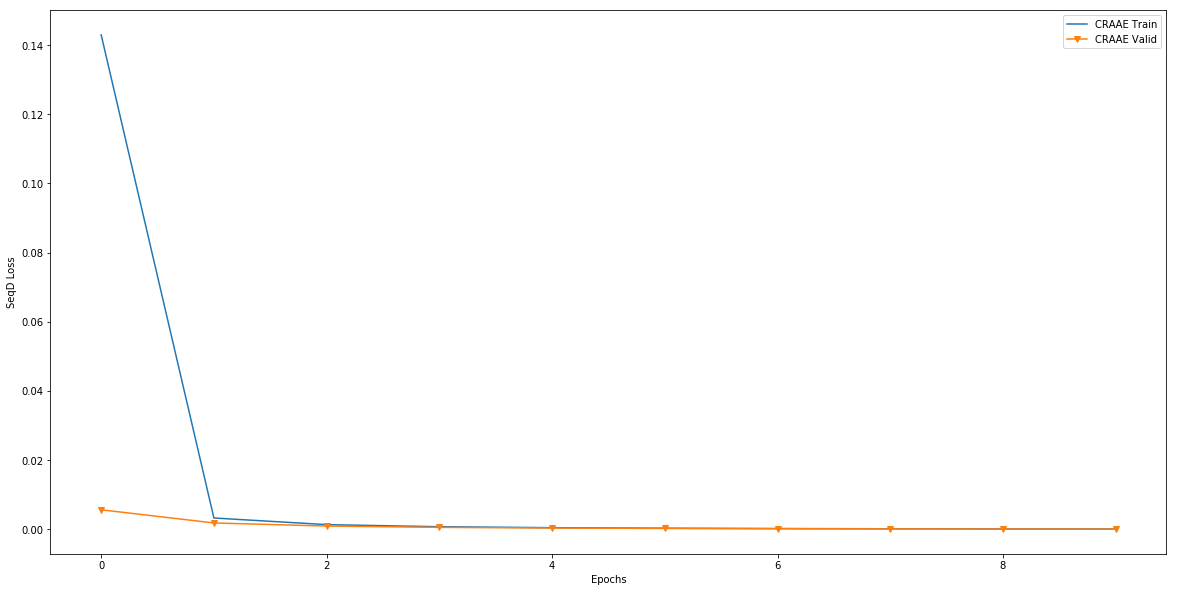

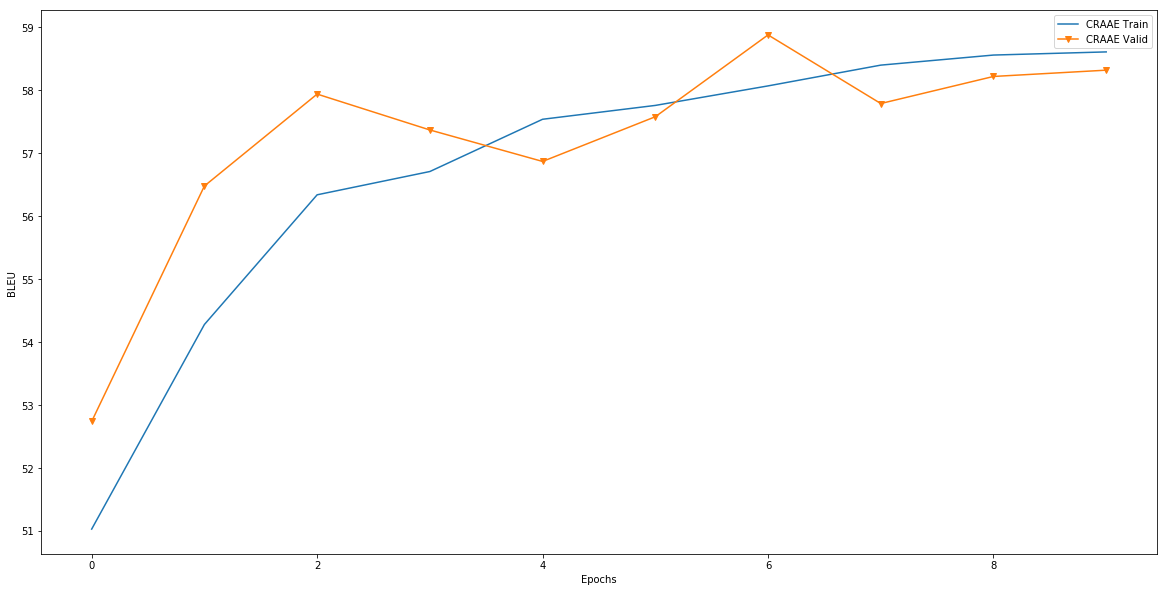

========== Start epoch 11 at 20:52:57 ==========
Epoch  11 Train: BLEU: 58.80, AE: 2.28224, G: 12.30597, ZD: 0.71355, SeqD: 0.00008  at 20:58:15
Epoch  11 Valid: BLEU: 59.41, AE: 2.23123, G: 12.33775, ZD: 0.73190, SeqD: 0.00006  at 20:58:21

Origin:  ['a person in safety orange clothing is lying atop an open manhole . <eos>']
Decoded: ['a man in a blue shirt and a shirt in a in a in']


Random sample:
	decoded w. style M: ['a man is in a , , the in the in the in the . <eos>']
	decoded w. style E: ['a man of a , , the , , the , , the p . <eos>']

========== Start epoch 12 at 20:58:21 ==========
Epoch  12 Train: BLEU: 58.97, AE: 2.22743, G: 12.51059, ZD: 0.71329, SeqD: 0.00006  at 21:03:39
Epoch  12 Valid: BLEU: 59.47, AE: 2.23513, G: 12.66759, ZD: 0.69017, SeqD: 0.00005  at 21:03:45

Origin:  ['a woman serves food on the side of the road . <eos>']
Decoded: ['a man is in a man , a man in the ball']


Random sample:
	decoded w. style M: ['a man of the , the ball of <eos>']
	decoded w. sty

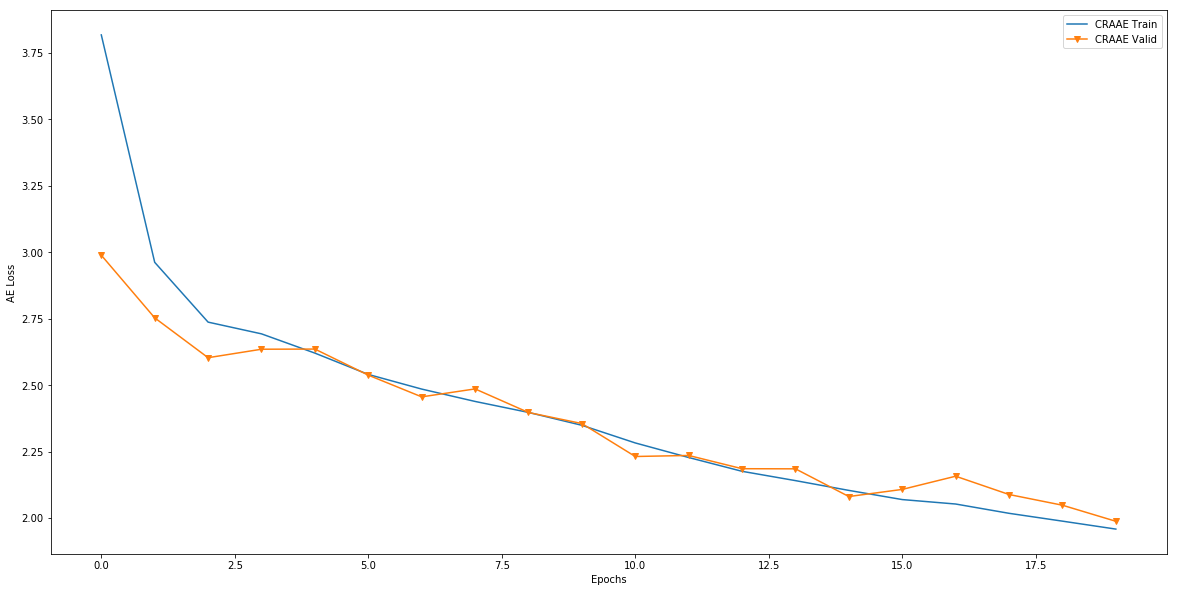

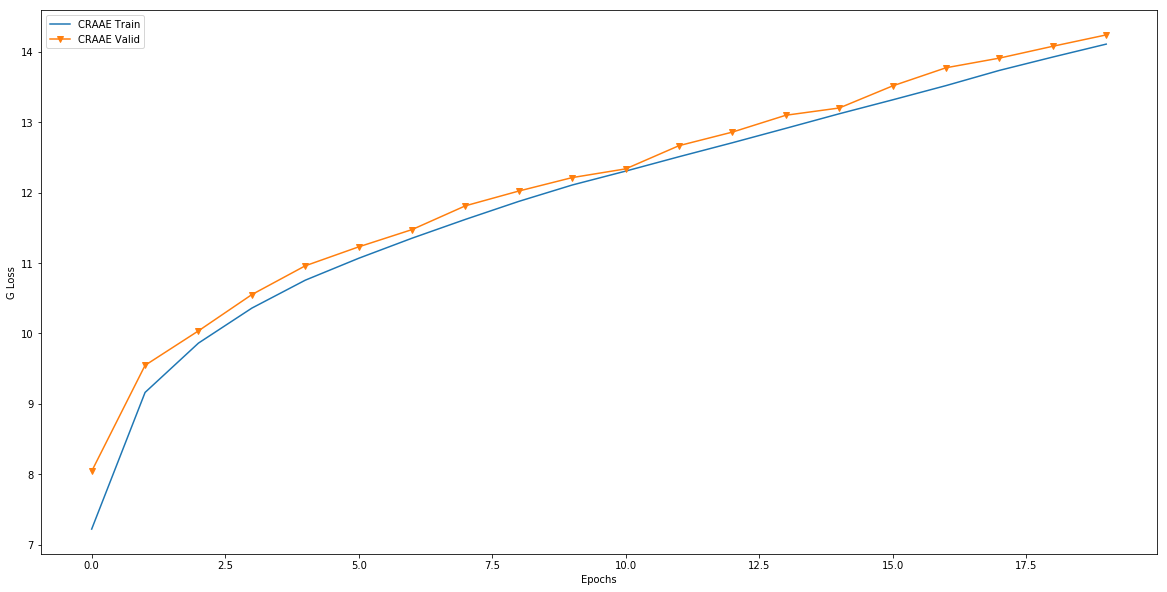

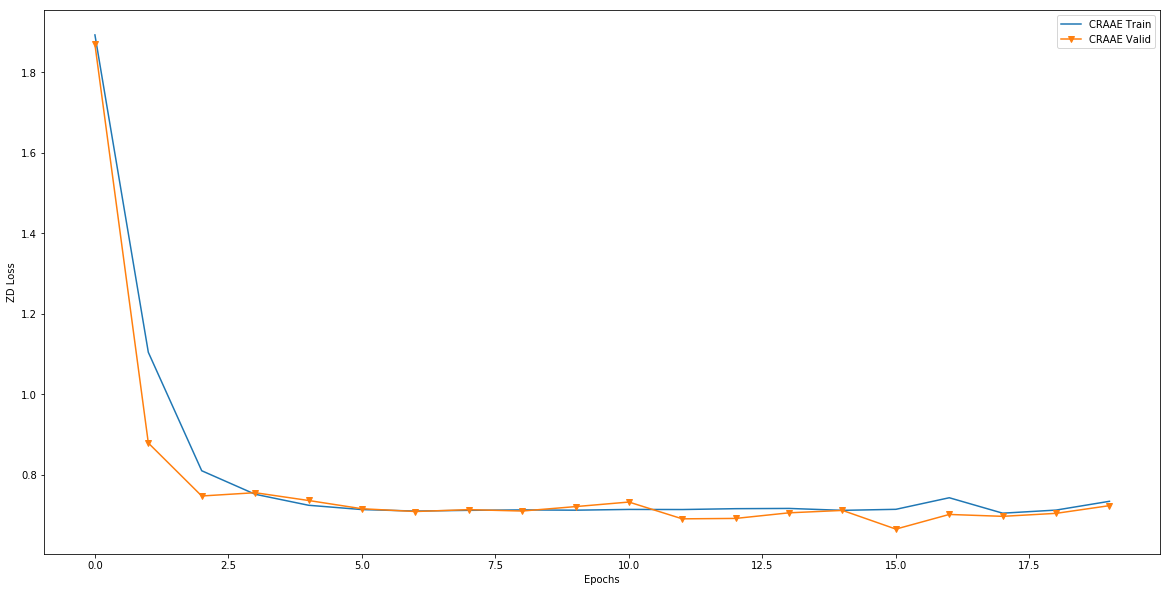

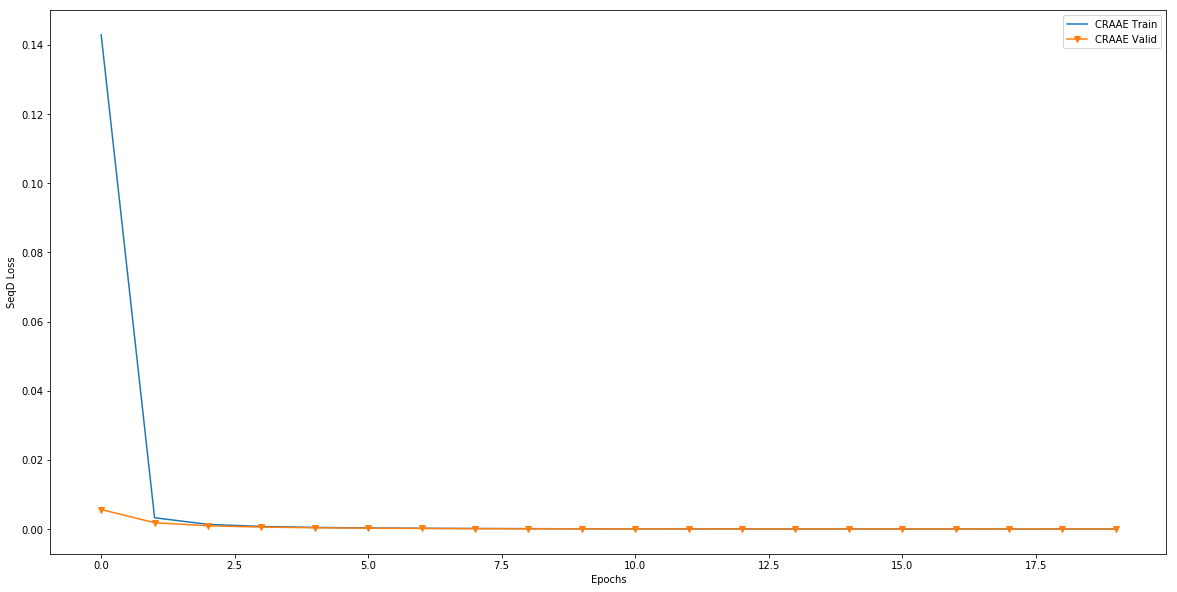

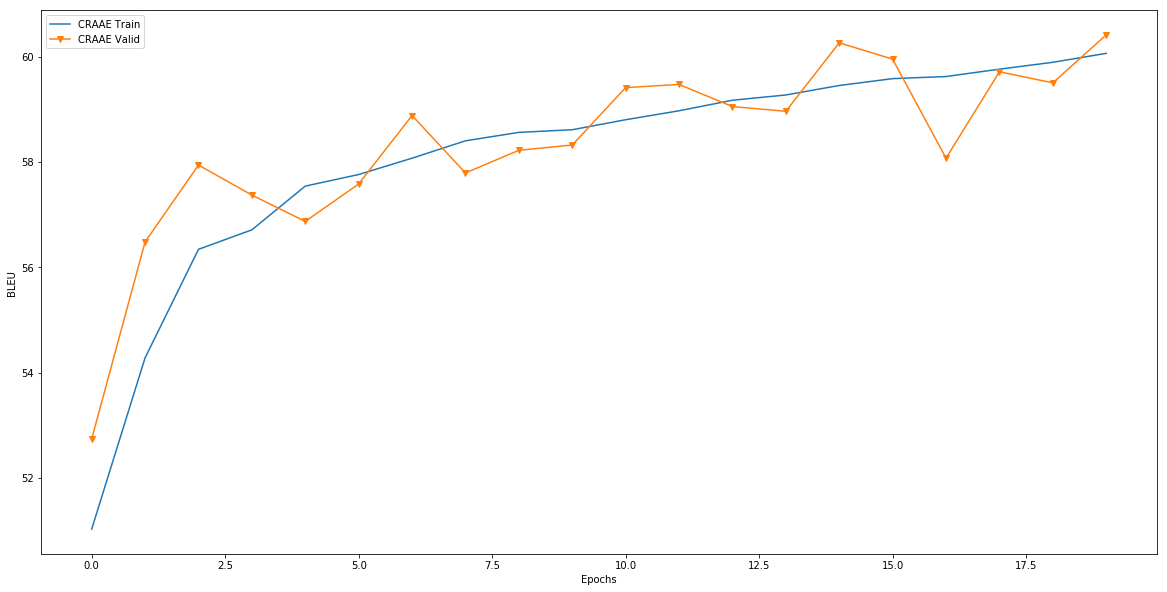

========== Start epoch 21 at 21:47:03 ==========
Epoch  21 Train: BLEU: 60.24, AE: 1.92085, G: 14.29938, ZD: 0.71791, SeqD: 0.00001  at 21:52:23
Epoch  21 Valid: BLEU: 60.57, AE: 1.95853, G: 14.50421, ZD: 0.68915, SeqD: 0.00001  at 21:52:29

Origin:  ['a tan dog shaking the water off of himself <eos>']
Decoded: ['a man is looking to a ball with a large']


Random sample:
	decoded w. style M: ['and the name , you a little bit of <eos>']
	decoded w. style E: ["and you 's a little , i 's back <eos>"]

========== Start epoch 22 at 21:52:29 ==========
Epoch  22 Train: BLEU: 60.36, AE: 1.89412, G: 14.50433, ZD: 0.70891, SeqD: 0.00001  at 21:57:48
Epoch  22 Valid: BLEU: 60.32, AE: 1.95746, G: 14.66379, ZD: 0.69206, SeqD: 0.00000  at 21:57:54

Origin:  ['a young blond girl holds a beach ball in the middle of a grass field . <eos>']
Decoded: ['a man in a blue top is looking on a large man in the background . <eos>']


Random sample:
	decoded w. style M: ["and the fuck , the little , , the way ,

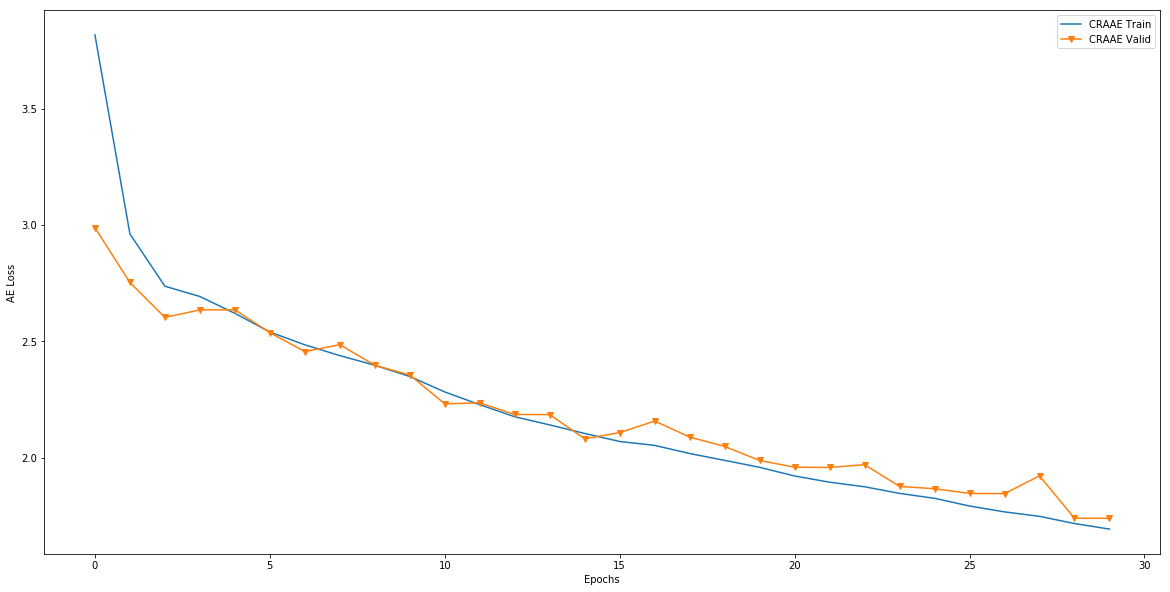

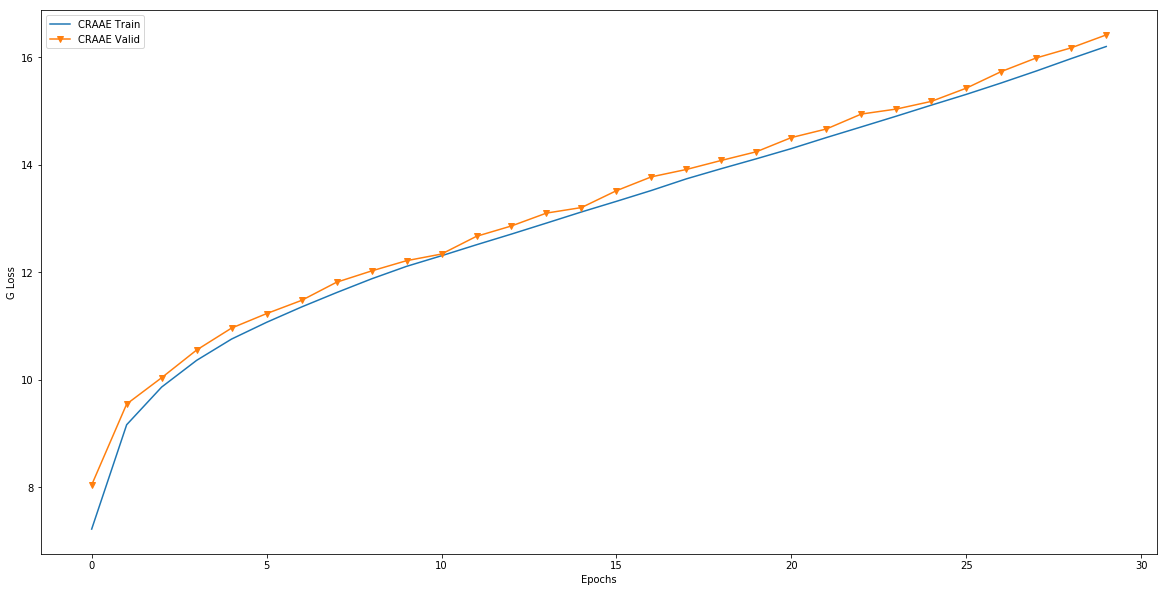

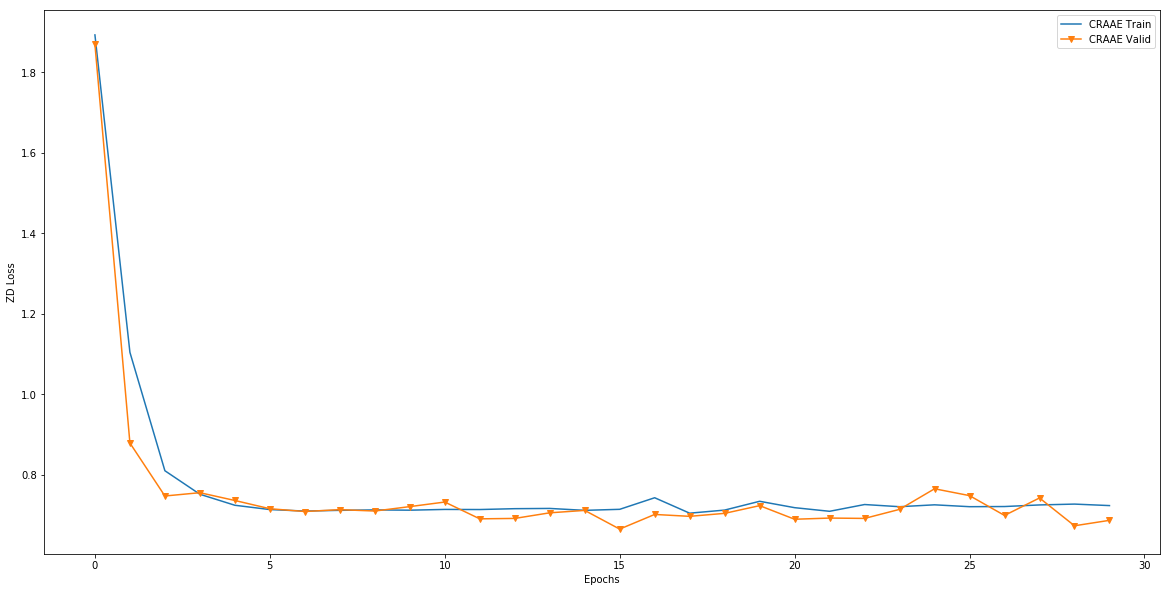

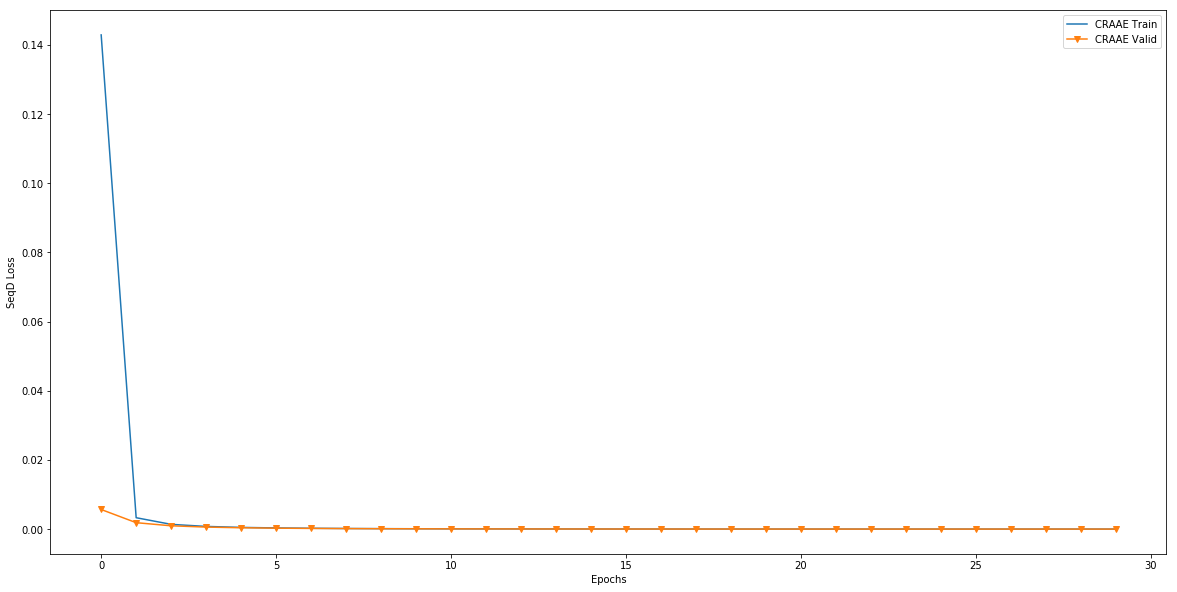

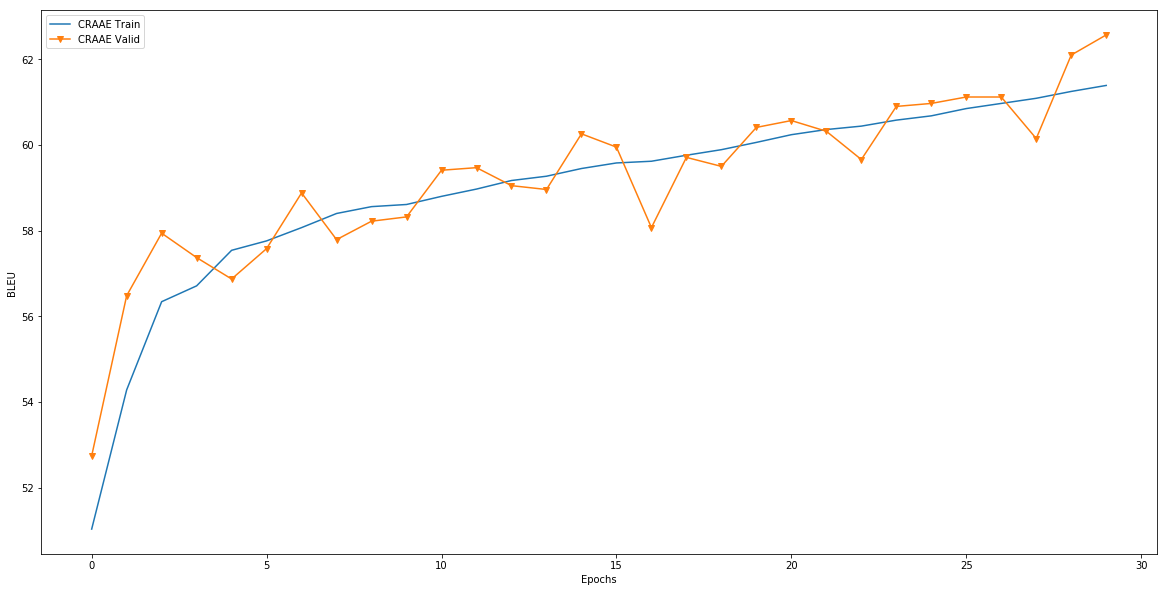

========== Start epoch 31 at 22:41:09 ==========
Epoch  31 Train: BLEU: 61.62, AE: 1.65698, G: 16.39537, ZD: 0.73978, SeqD: 0.00000  at 22:46:27
Epoch  31 Valid: BLEU: 62.29, AE: 1.70542, G: 16.59737, ZD: 0.69170, SeqD: 0.00000  at 22:46:33

Origin:  ['two dogs are running together through mowed grass . <eos>']
Decoded: ['two men are looking at a table at the game']


Random sample:
	decoded w. style M: ['a person with an orange , and two a child while another other . <eos>']
	decoded w. style E: ['a group of people are on a table while a ball at the street . <eos>']

========== Start epoch 32 at 22:46:33 ==========
Epoch  32 Train: BLEU: 61.86, AE: 1.62140, G: 16.59532, ZD: 0.72603, SeqD: 0.00000  at 22:51:52
Epoch  32 Valid: BLEU: 62.20, AE: 1.69087, G: 16.73827, ZD: 0.73526, SeqD: 0.00000  at 22:51:58

Origin:  ['a tan dog shaking the water off of himself <eos>']
Decoded: ['a young boy is looking at a street while a']


Random sample:
	decoded w. style M: ['a group is trying to catc

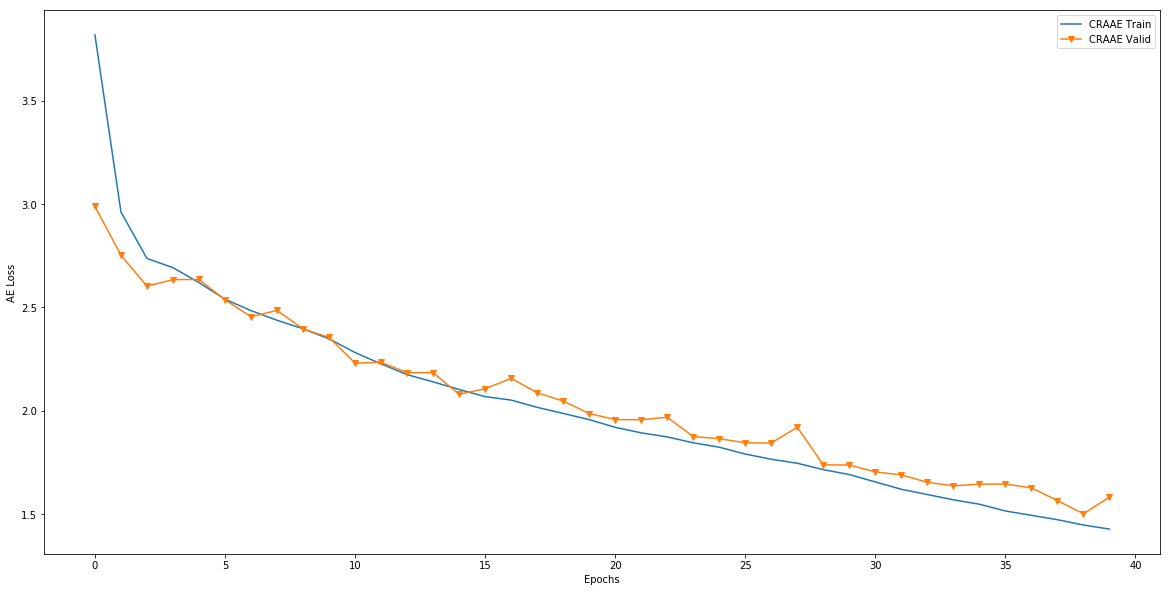

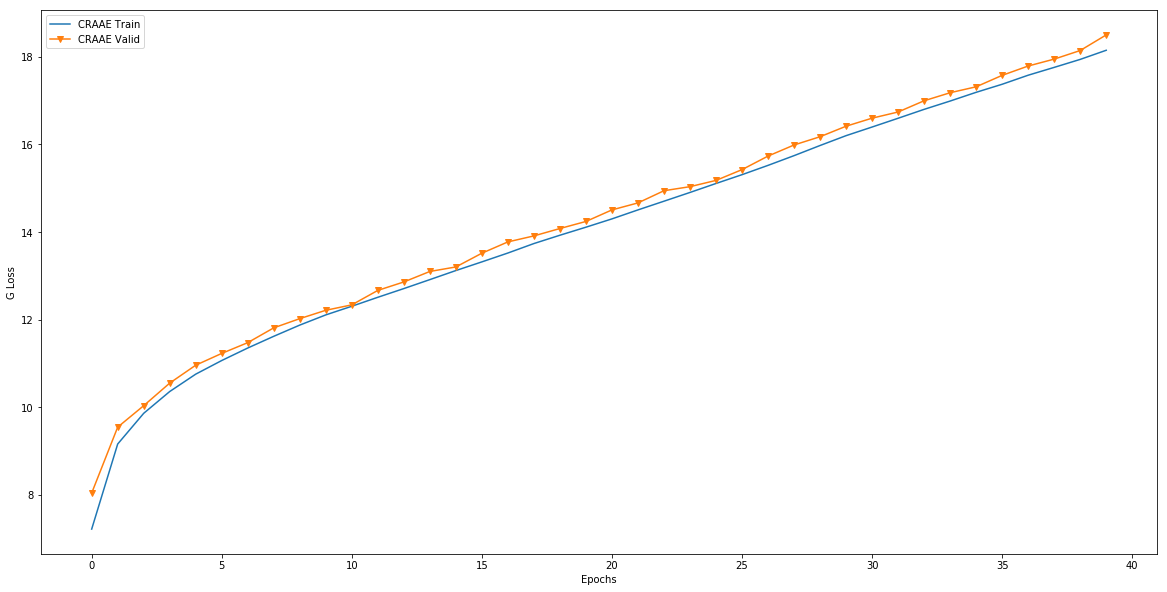

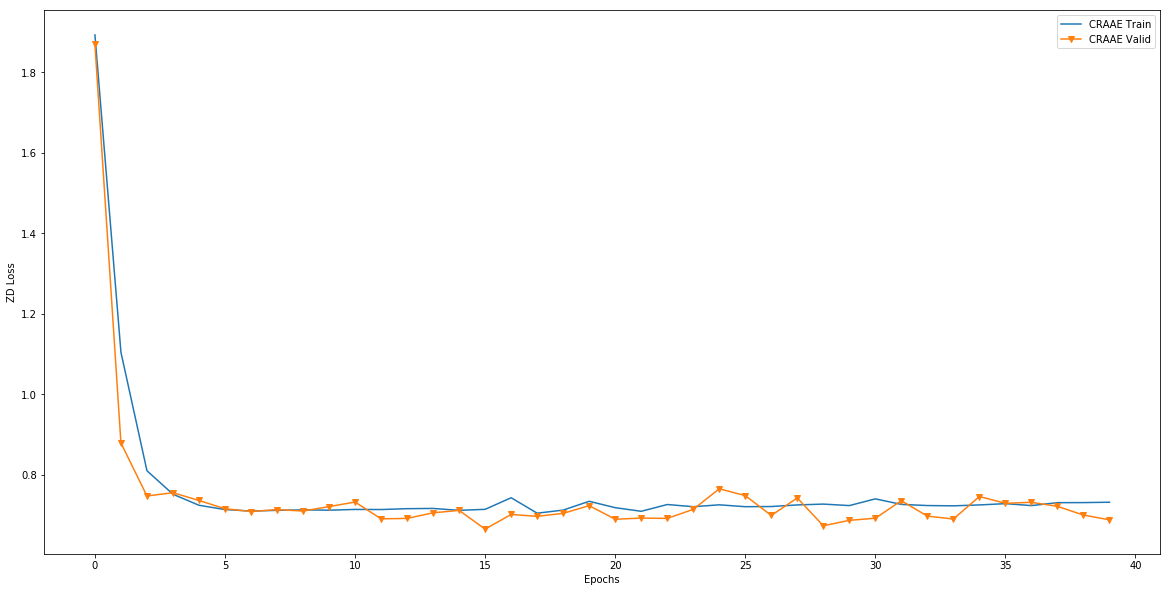

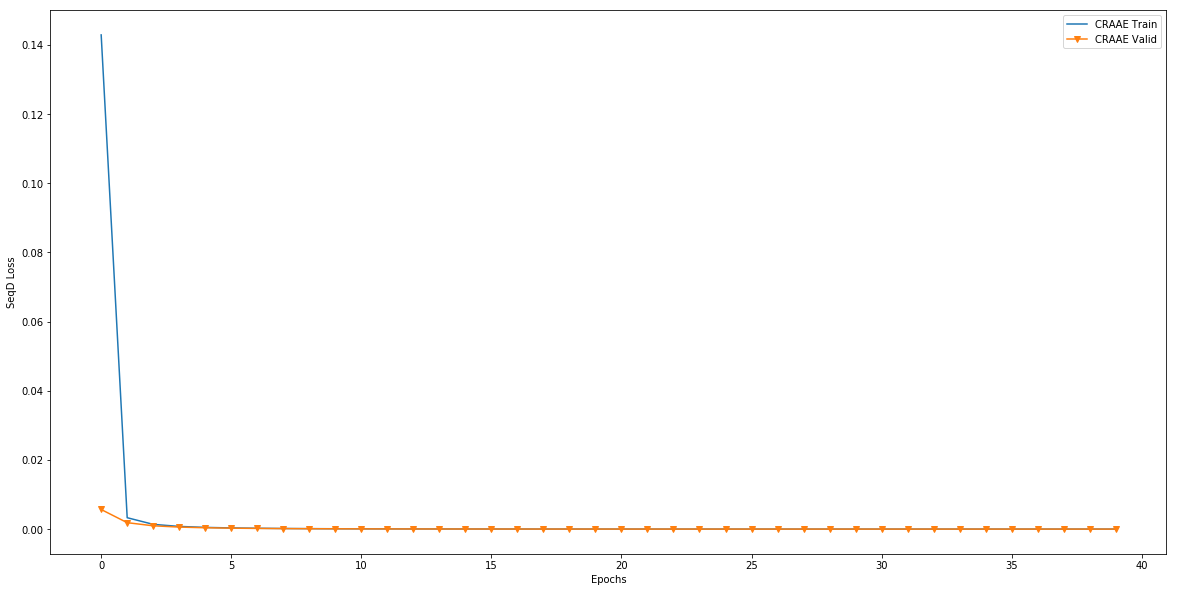

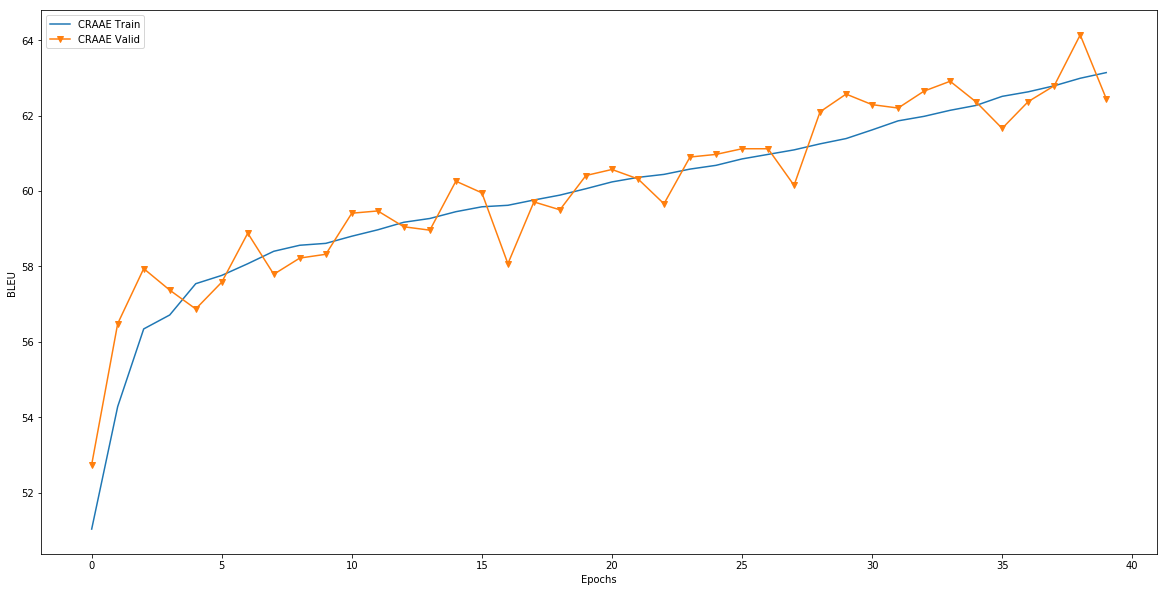

========== Start epoch 41 at 23:35:16 ==========
Epoch  41 Train: BLEU: 63.47, AE: 1.39087, G: 18.35191, ZD: 0.72323, SeqD: 0.00000  at 23:40:32
Epoch  41 Valid: BLEU: 64.01, AE: 1.49637, G: 18.55298, ZD: 0.70814, SeqD: 0.00000  at 23:40:38

Origin:  ['i got a gat man <eos>']
Decoded: ["i 'll a little boy and"]


Random sample:
	decoded w. style M: ["and you 're playing and <eos>"]
	decoded w. style E: ["and i 'm playing up <eos>"]

========== Start epoch 42 at 23:40:38 ==========
Epoch  42 Train: BLEU: 63.50, AE: 1.38415, G: 18.53175, ZD: 0.73139, SeqD: 0.00000  at 23:45:56
Epoch  42 Valid: BLEU: 63.76, AE: 1.49881, G: 18.67683, ZD: 0.76521, SeqD: 0.00000  at 23:46:02

Origin:  ['you just a . hoe <eos>']
Decoded: ["i 'm the two white ,"]


Random sample:
	decoded w. style M: ["you 're so so you , you <eos>"]
	decoded w. style E: ['you know me to be go <eos>']

========== Start epoch 43 at 23:46:02 ==========
Epoch  43 Train: BLEU: 63.86, AE: 1.34531, G: 18.69760, ZD: 0.73309, SeqD: 0.

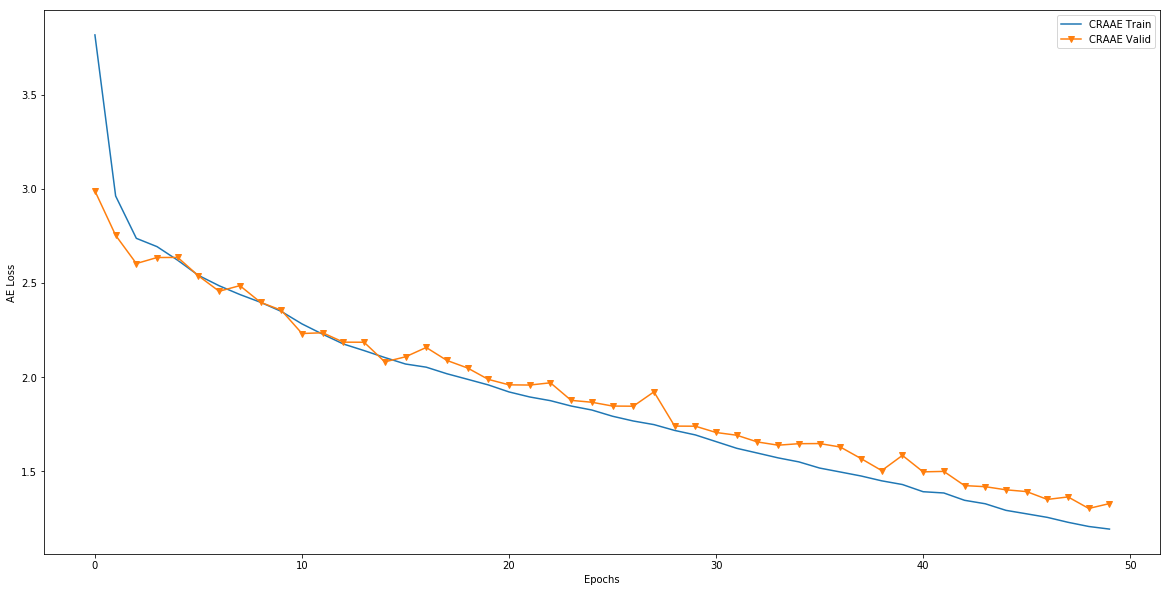

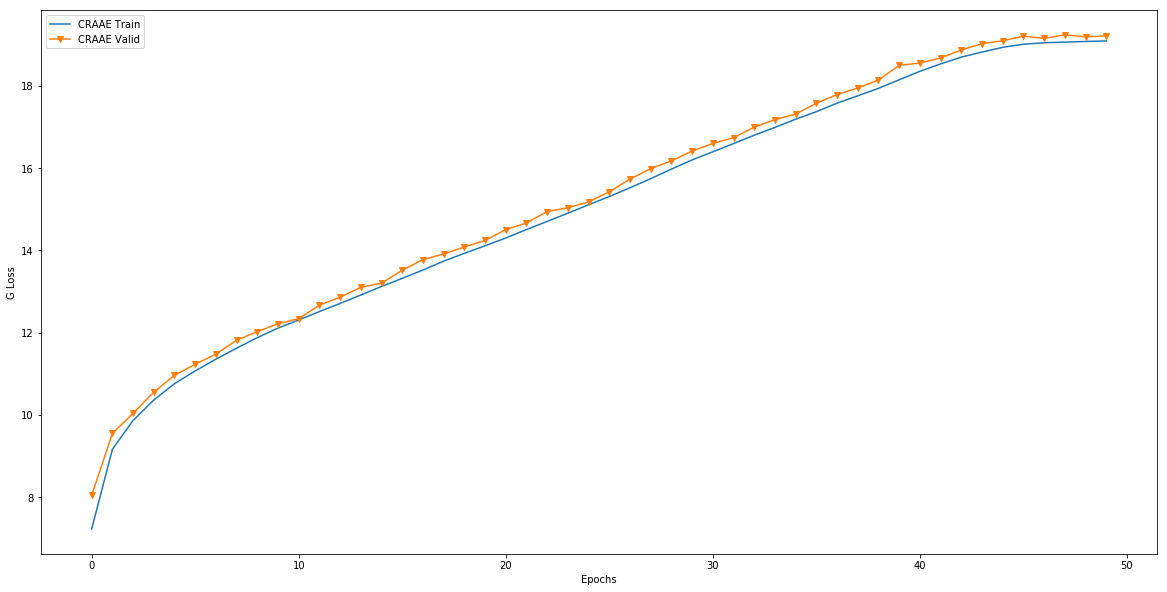

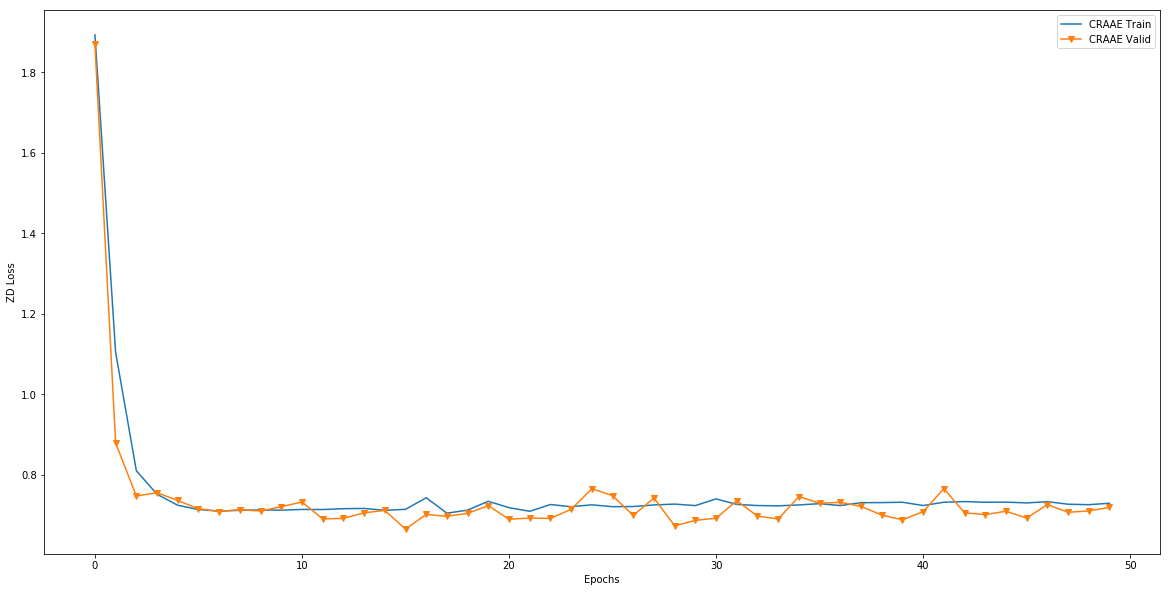

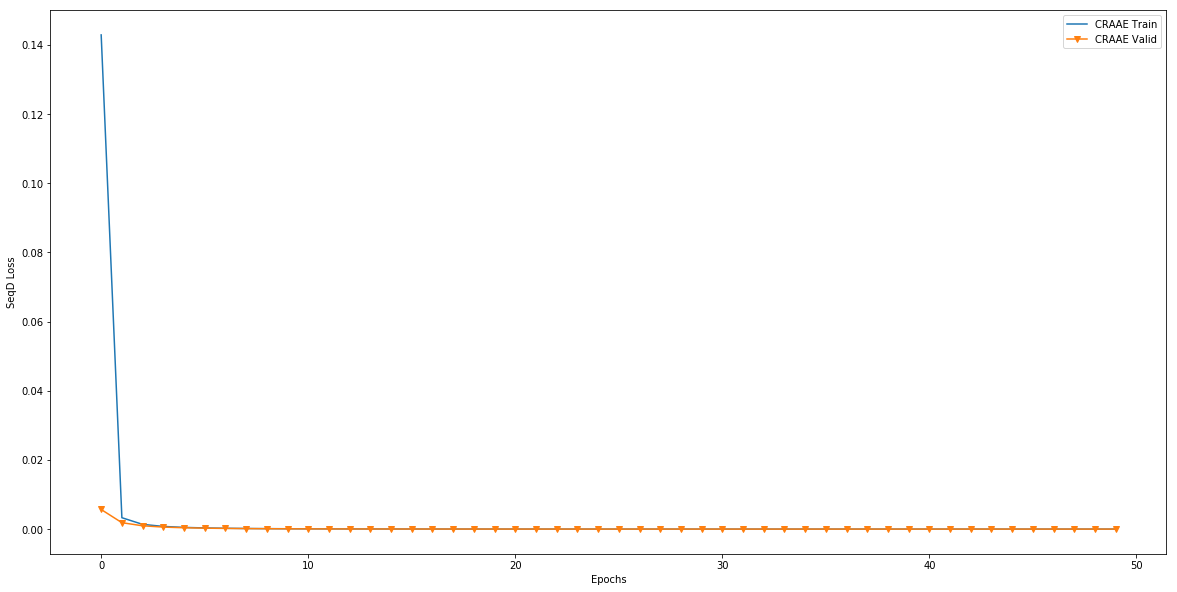

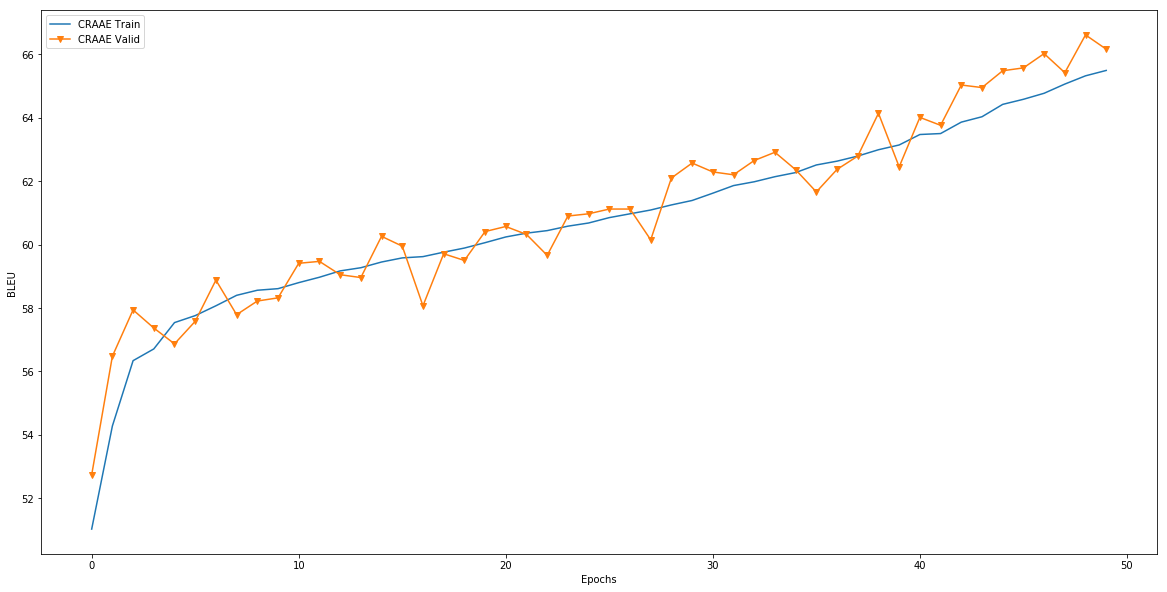

========== Start epoch 51 at 00:30:22 ==========
Epoch  51 Train: BLEU: 65.63, AE: 1.17708, G: 19.09986, ZD: 0.72937, SeqD: 0.00000  at 00:35:58
Epoch  51 Valid: BLEU: 65.53, AE: 1.34903, G: 19.35230, ZD: 0.67460, SeqD: 0.00000  at 00:36:04

Origin:  ['i got grenades <eos>']
Decoded: ["i 'll get a"]


Random sample:
	decoded w. style M: ['the two of young standing and one with their in water . <eos>']
	decoded w. style E: ['the morning and my hair and his back and her pills <eos>']

========== Start epoch 52 at 00:36:04 ==========
Epoch  52 Train: BLEU: 65.97, AE: 1.15466, G: 19.09530, ZD: 0.73910, SeqD: 0.00000  at 00:41:43
Epoch  52 Valid: BLEU: 66.71, AE: 1.27310, G: 19.20970, ZD: 0.72354, SeqD: 0.00000  at 00:41:50

Origin:  ['people are traveling via donkey with their belongings on back . <eos>']
Decoded: ['an adult officer has a baby race at a table on .']


Random sample:
	decoded w. style M: ['a basketball player is performing to a race . <eos>']
	decoded w. style E: ['of all a

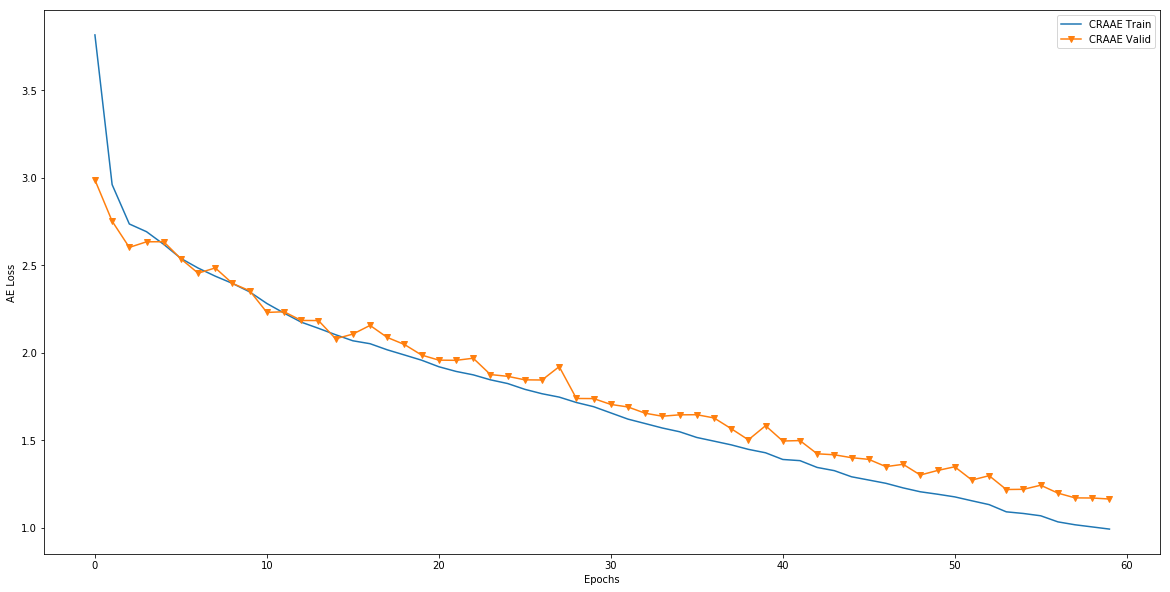

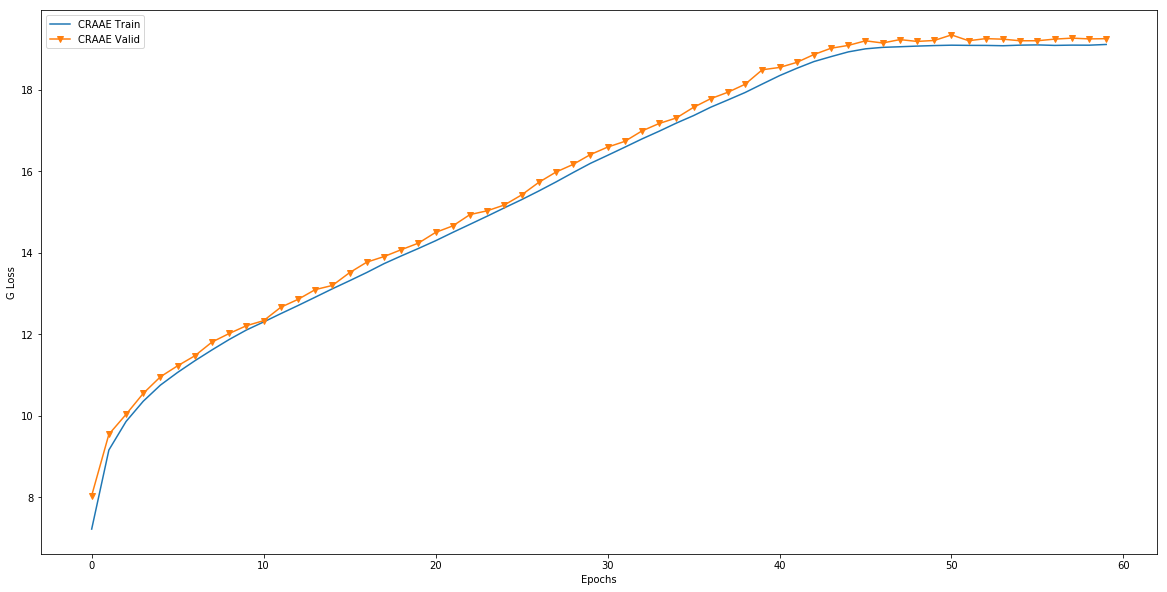

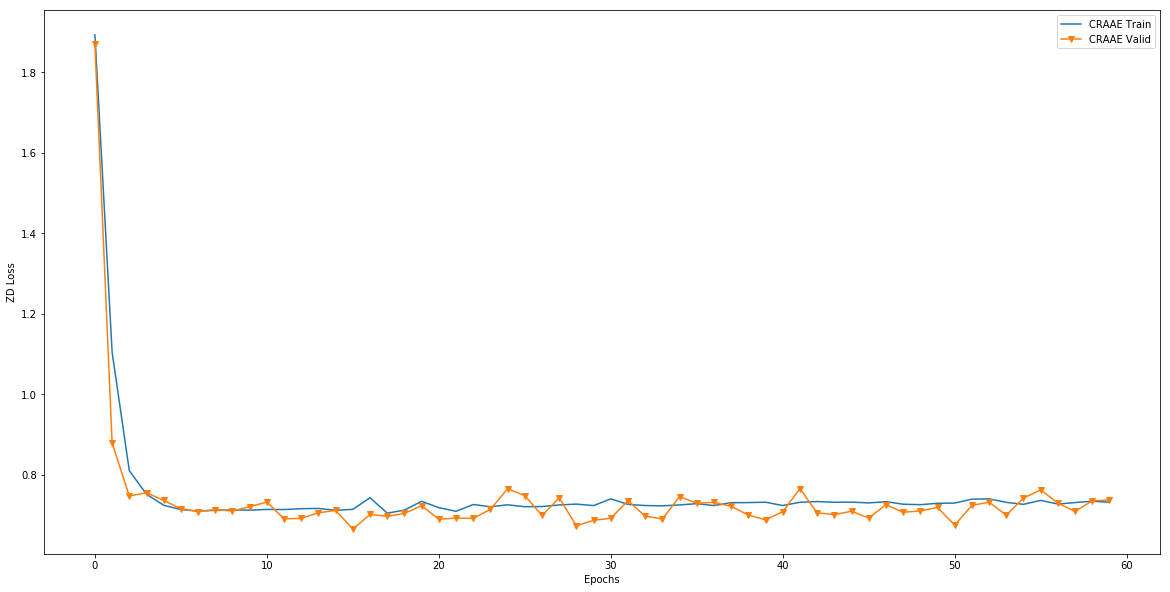

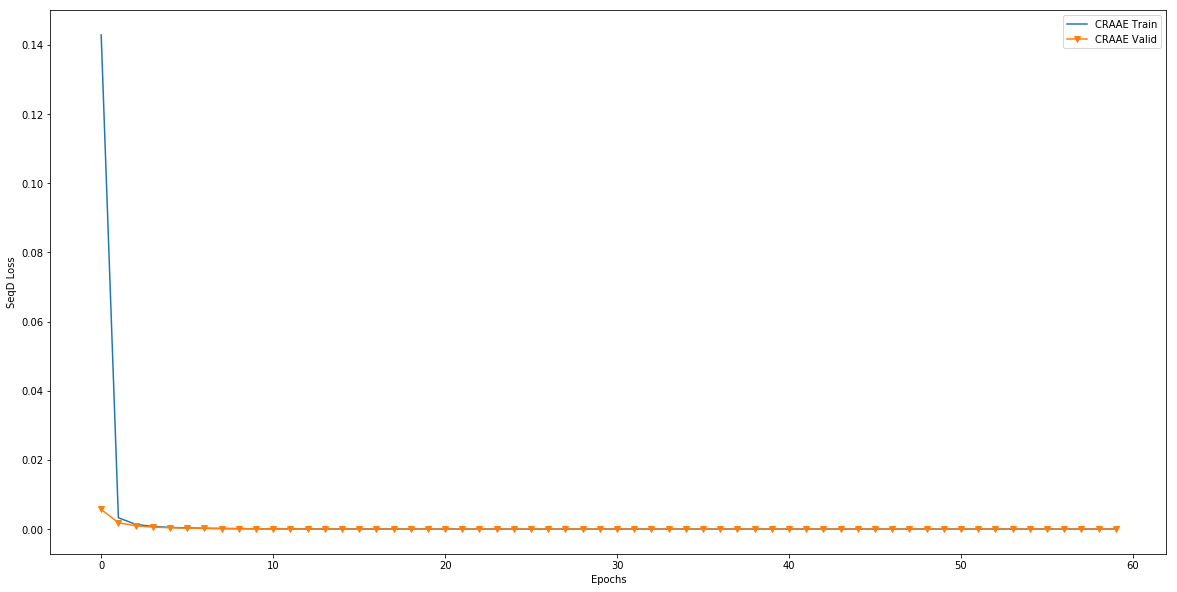

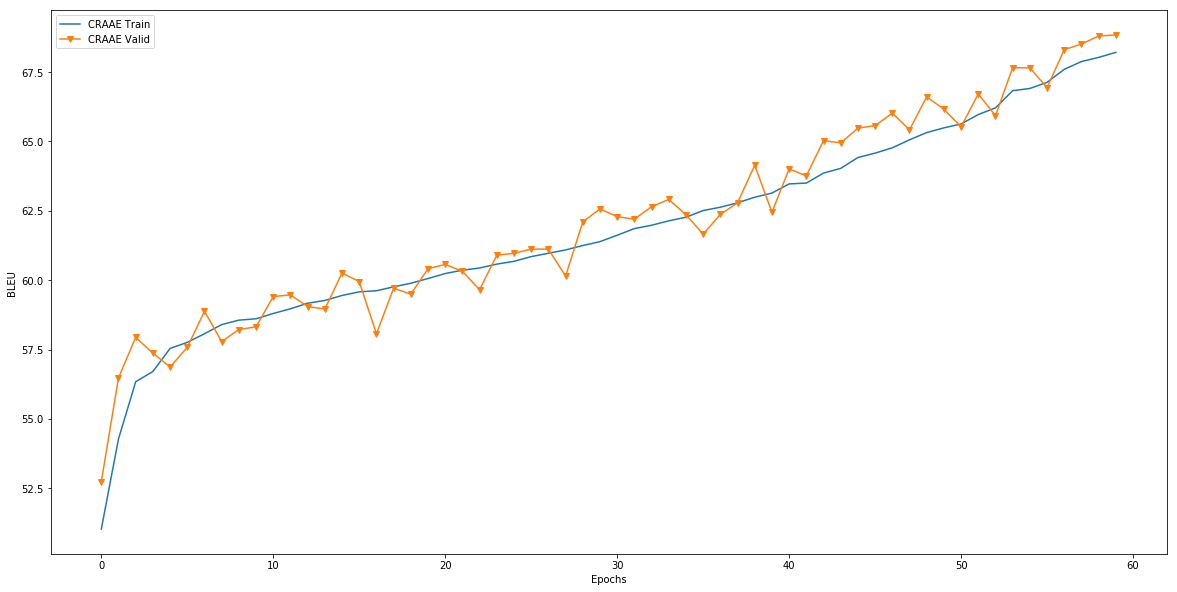

========== Start epoch 61 at 01:25:46 ==========
Epoch  61 Train: BLEU: 68.50, AE: 0.97708, G: 19.10894, ZD: 0.73866, SeqD: 0.00000  at 01:31:06
Epoch  61 Valid: BLEU: 70.17, AE: 1.09409, G: 19.22516, ZD: 0.72341, SeqD: 0.00000  at 01:31:11

Origin:  ["if i have a daughter , guess what i 'm a call her ? <eos>"]
Decoded: ['if i have a fuck , but i ai nt the real thing ? <eos>']


Random sample:
	decoded w. style M: ['two people having a picture of a child on an empty game . <eos>']
	decoded w. style E: ['all it comes the hop with my ass , the day <eos>']

========== Start epoch 62 at 01:31:11 ==========
Epoch  62 Train: BLEU: 69.24, AE: 0.93450, G: 19.10217, ZD: 0.71664, SeqD: 0.00000  at 01:36:32
Epoch  62 Valid: BLEU: 69.52, AE: 1.11640, G: 19.24907, ZD: 0.72836, SeqD: 0.00000  at 01:36:38

Origin:  ["yes i 'm the real shady <eos>"]
Decoded: ["'cause i 'm the real thing to"]


Random sample:
	decoded w. style M: ['a baby player is leaping into the . <eos>']
	decoded w. style E: ['tire

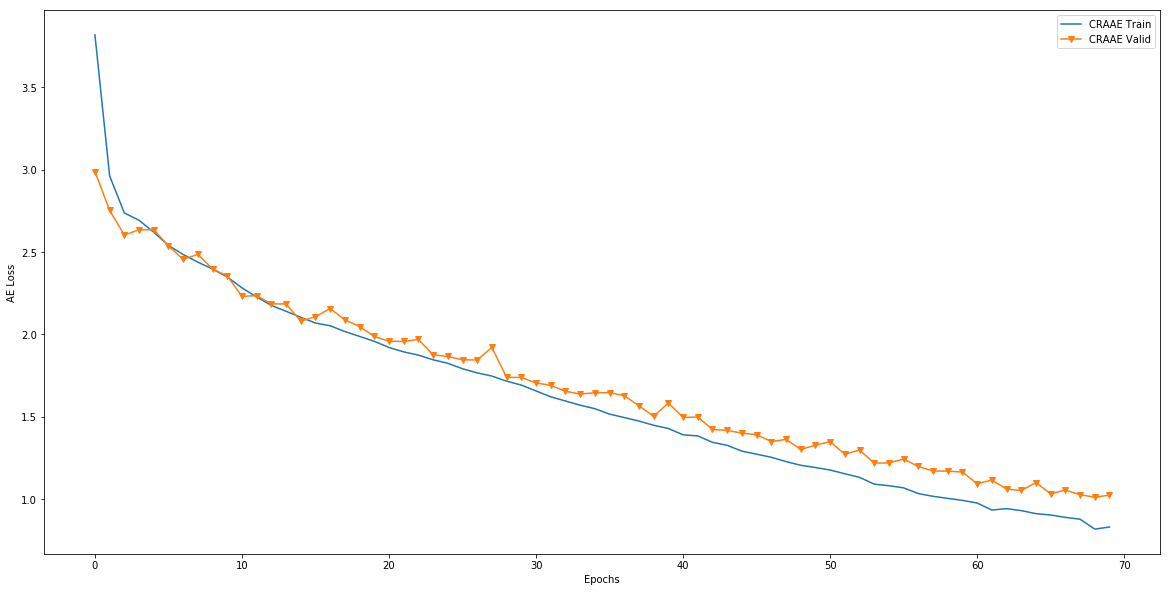

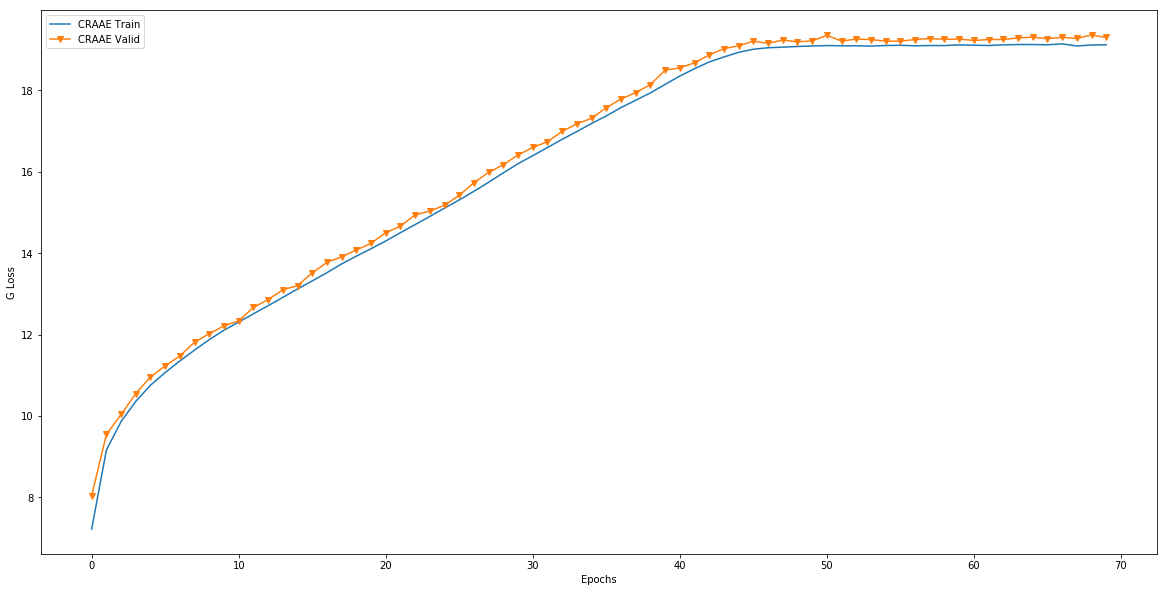

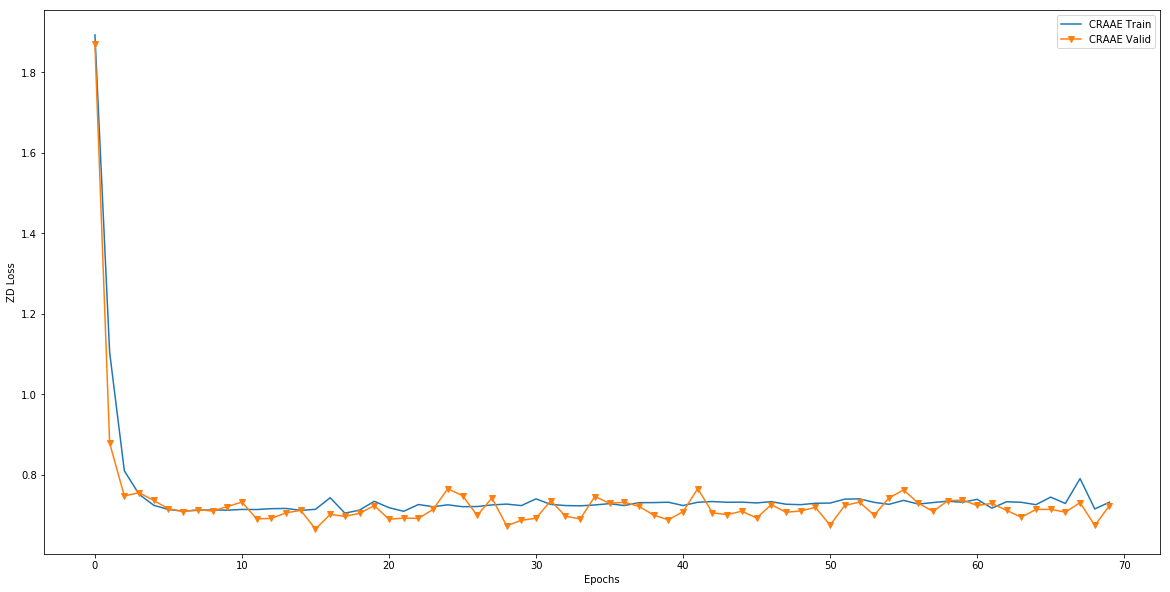

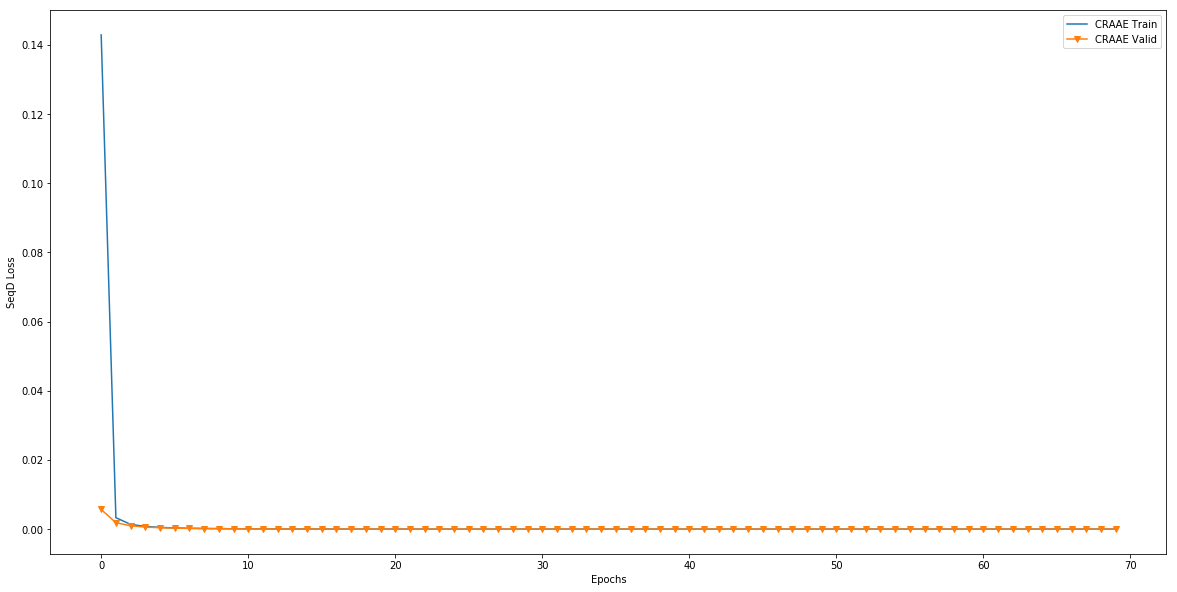

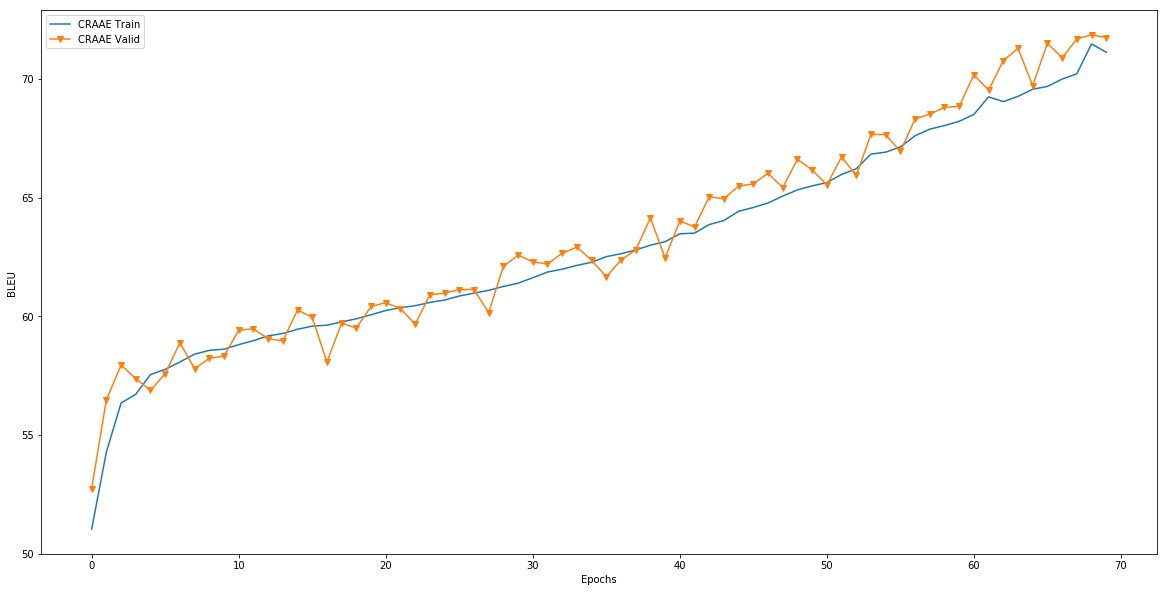

========== Start epoch 71 at 02:20:12 ==========
Epoch  71 Train: BLEU: 71.35, AE: 0.82207, G: 19.11306, ZD: 0.74039, SeqD: 0.00000  at 02:25:30
Epoch  71 Valid: BLEU: 72.54, AE: 0.98380, G: 19.28413, ZD: 0.71510, SeqD: 0.00000  at 02:25:36

Origin:  ['grin and bear it <eos>']
Decoded: ['yo in his world have']


Random sample:
	decoded w. style M: ['a lady walking up music . <eos>']
	decoded w. style E: ['a little bit of smoothies . <eos>']

========== Start epoch 72 at 02:25:36 ==========
Epoch  72 Train: BLEU: 72.00, AE: 0.78639, G: 19.09700, ZD: 0.72701, SeqD: 0.00000  at 02:30:56
Epoch  72 Valid: BLEU: 72.75, AE: 0.97667, G: 19.29696, ZD: 0.71277, SeqD: 0.00000  at 02:31:02

Origin:  ['motherf ers <eos>']
Decoded: ['fuckin run g']


Random sample:
	decoded w. style M: ["that of me if all all guys , we 're gon ' fuckin and kris kross <eos>"]
	decoded w. style E: ["that long if this dick 's , is as you see no raps or minutes <eos>"]

========== Start epoch 73 at 02:31:02 ==========
E

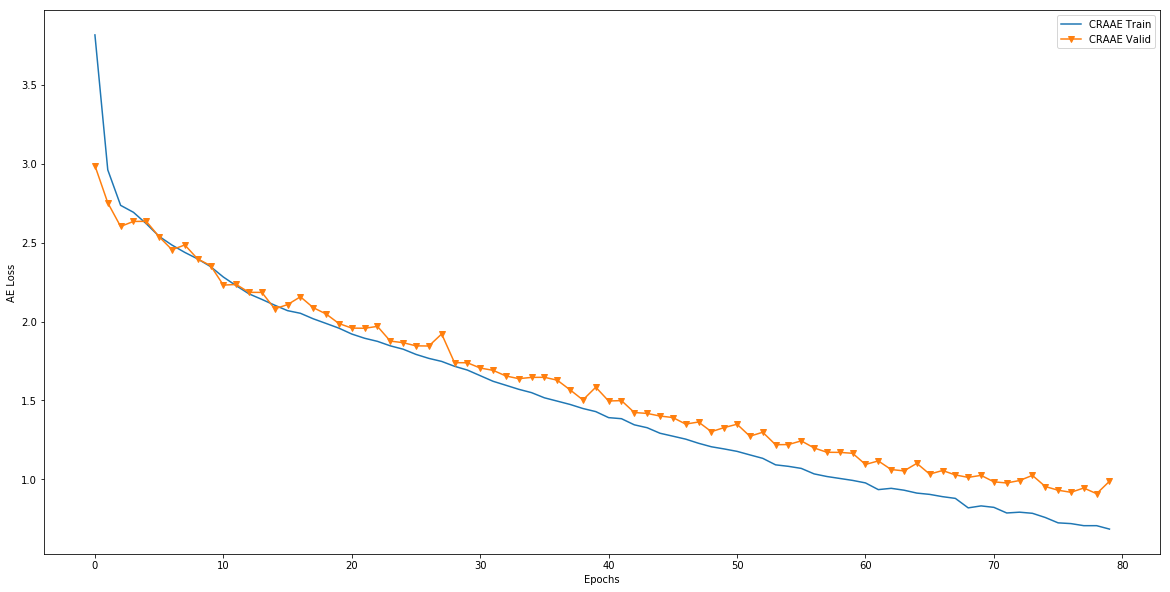

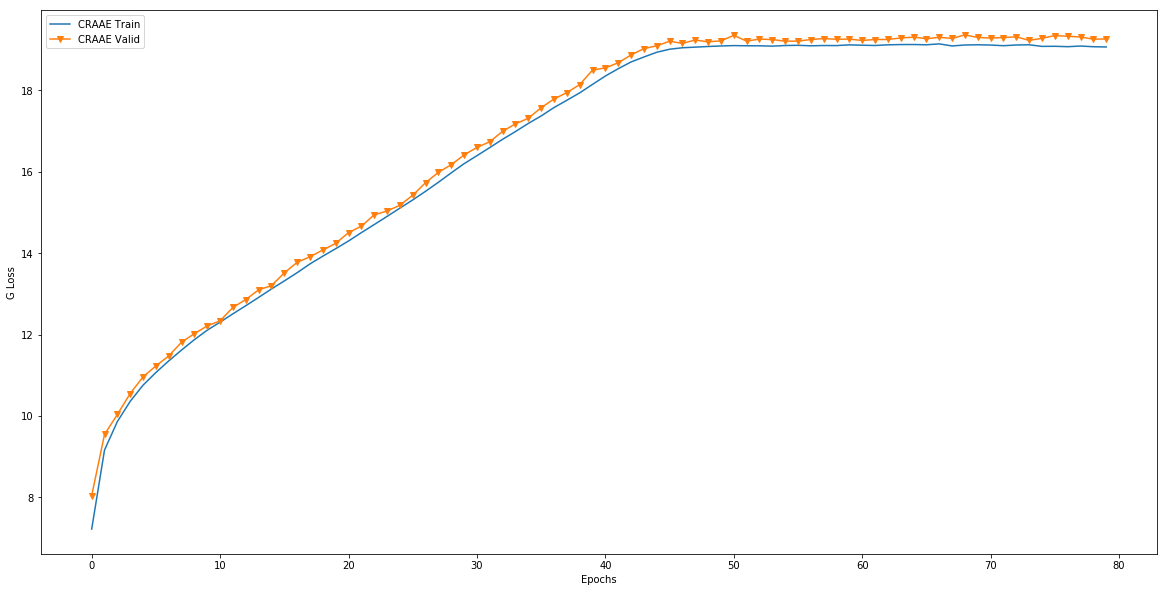

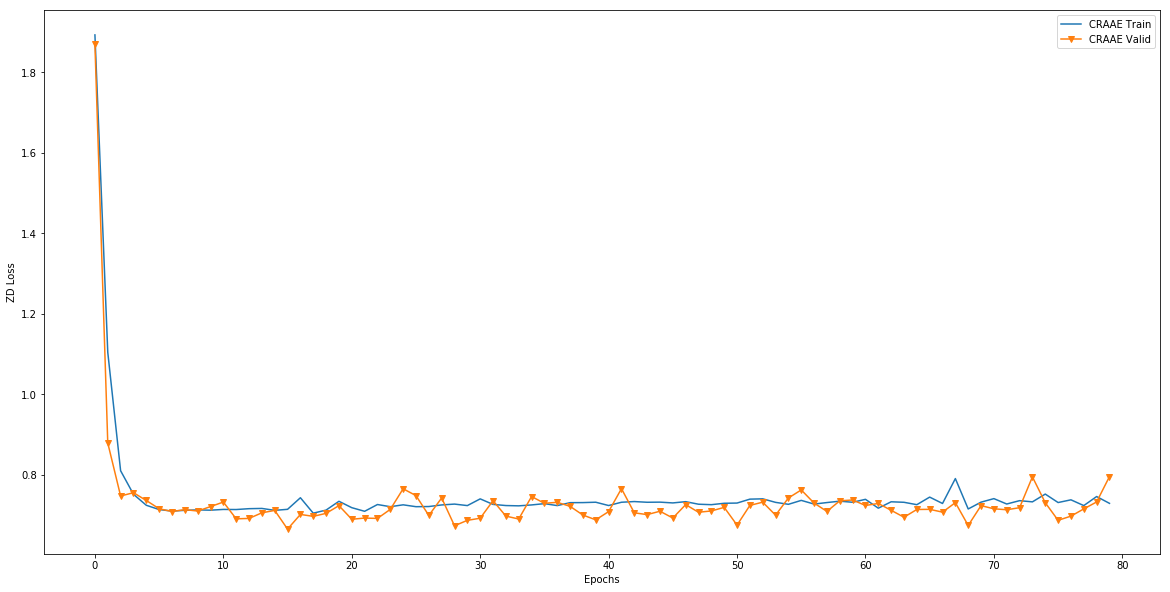

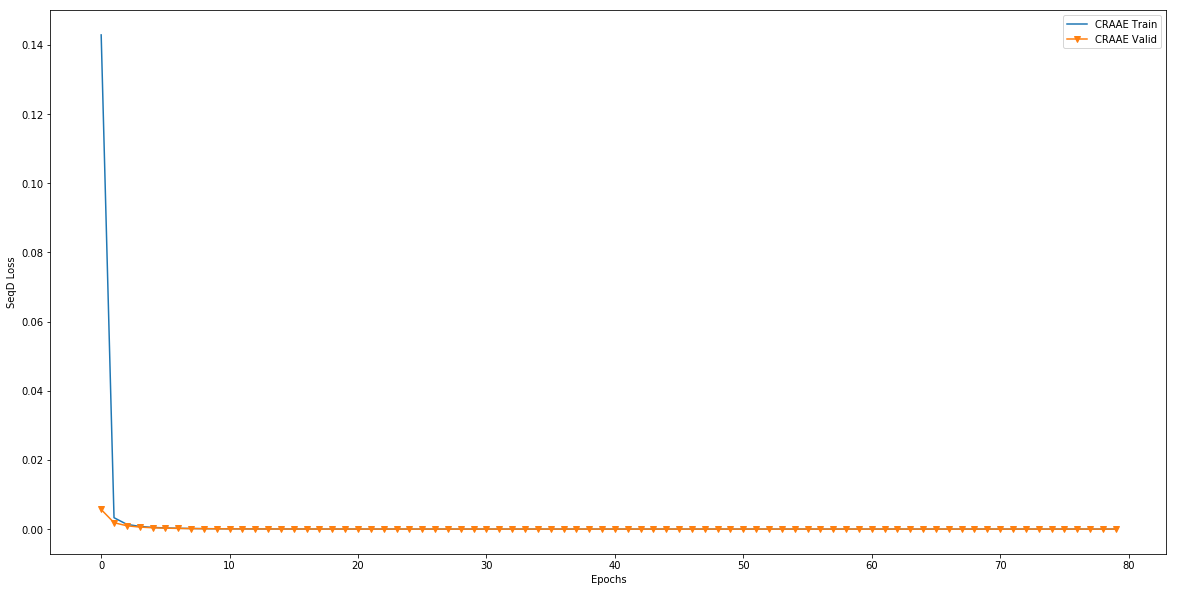

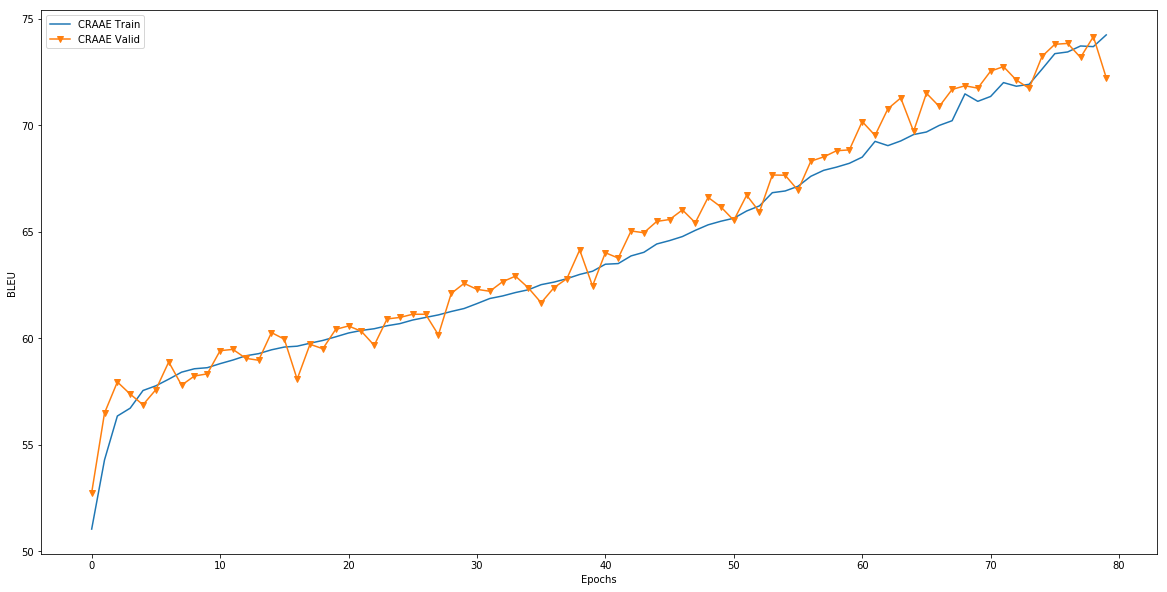

========== Start epoch 81 at 03:14:28 ==========
Epoch  81 Train: BLEU: 74.09, AE: 0.68832, G: 19.09442, ZD: 0.72628, SeqD: 0.00000  at 03:19:48
Epoch  81 Valid: BLEU: 73.40, AE: 0.94233, G: 19.24760, ZD: 0.77081, SeqD: 0.00000  at 03:19:54

Origin:  ['a person is riding a bike on a dirt road . <eos>']
Decoded: ['a person is riding a bike on a dirt road . <eos>']


Random sample:
	decoded w. style M: ['a person holding a white object with two women walk on the . <eos>']
	decoded w. style E: ['a child of a black dog in the pool cheering around . <eos>']

========== Start epoch 82 at 03:19:54 ==========
Epoch  82 Train: BLEU: 75.00, AE: 0.65338, G: 19.03897, ZD: 0.74879, SeqD: 0.00000  at 03:25:15
Epoch  82 Valid: BLEU: 75.25, AE: 0.87458, G: 19.32310, ZD: 0.68351, SeqD: 0.00000  at 03:25:21

Origin:  ["but no one really gives a fuck cause they just like what 's spinnin ' <eos>"]
Decoded: ['but no one ai nt one of me would it for me to be stomach <eos>']


Random sample:
	decoded w. styl

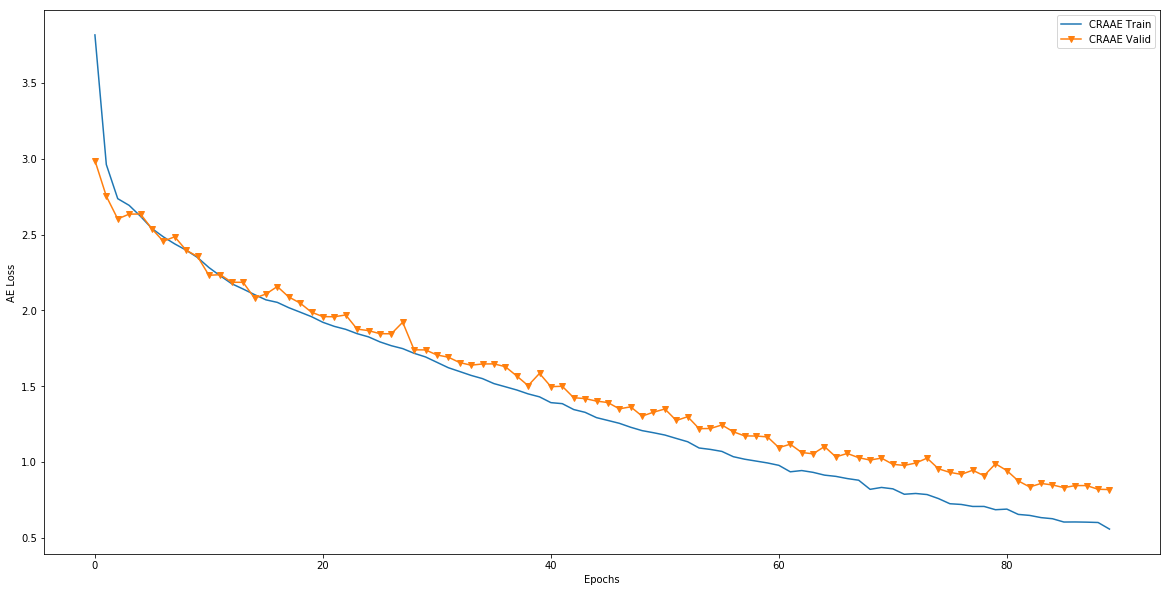

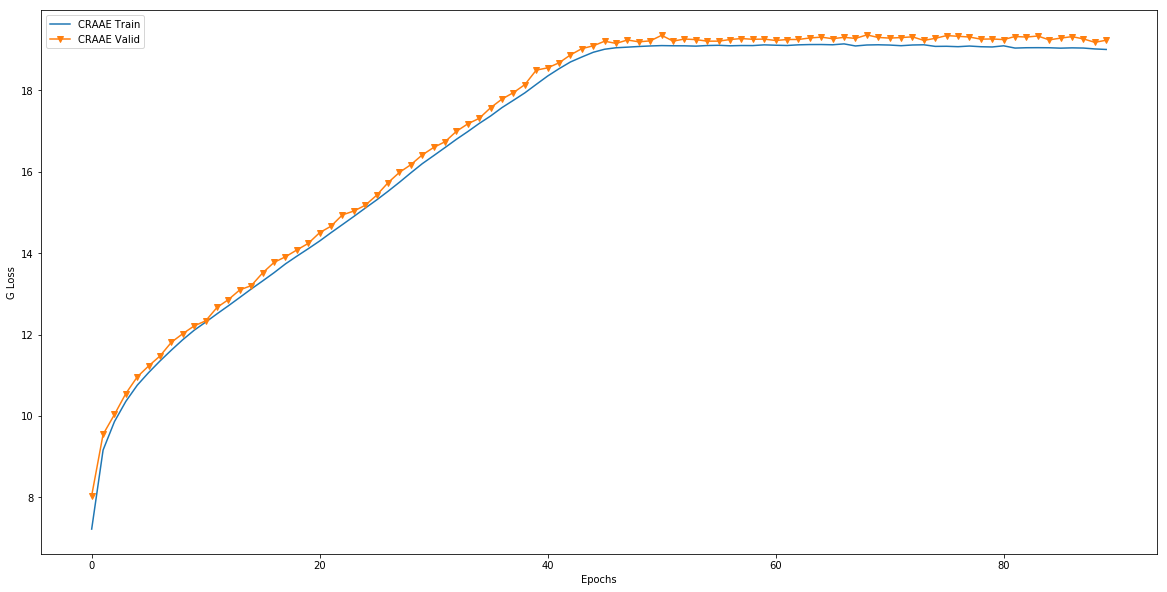

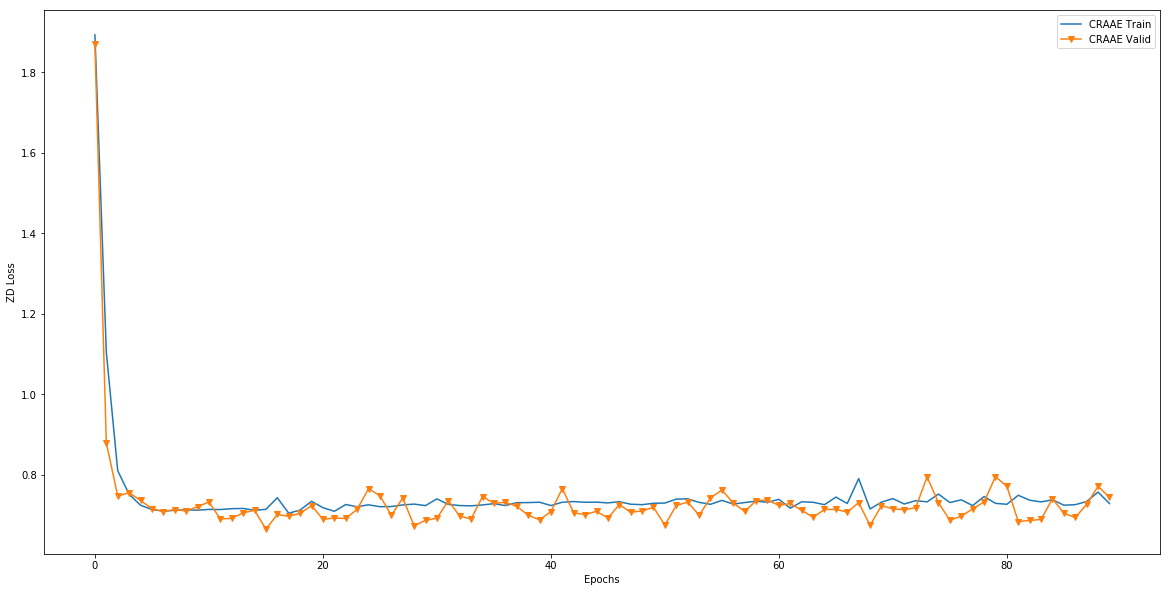

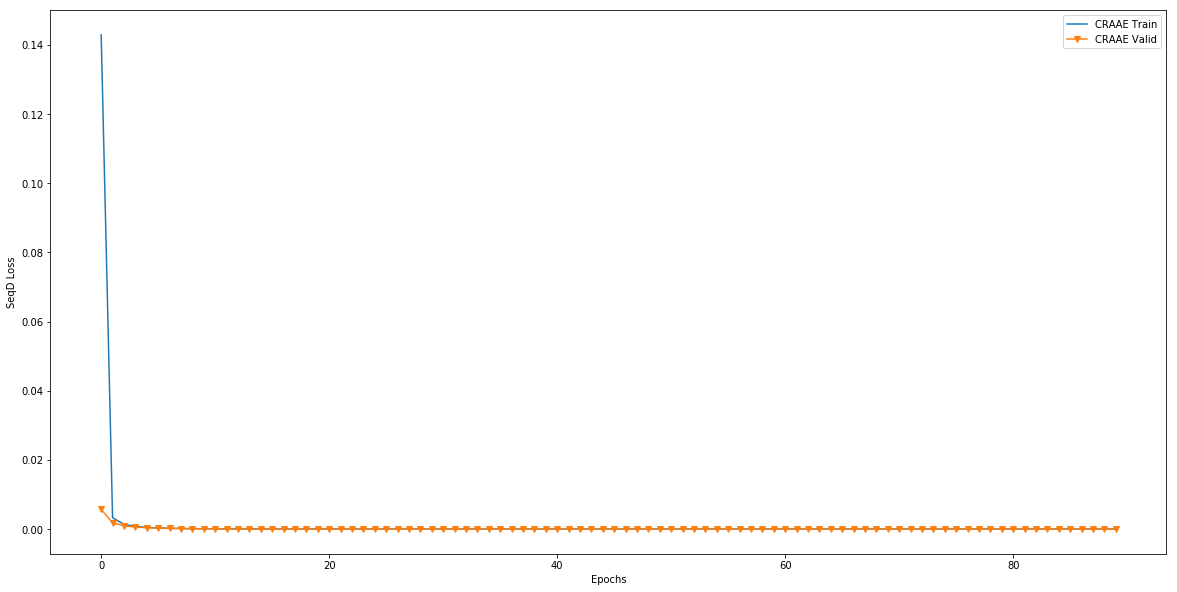

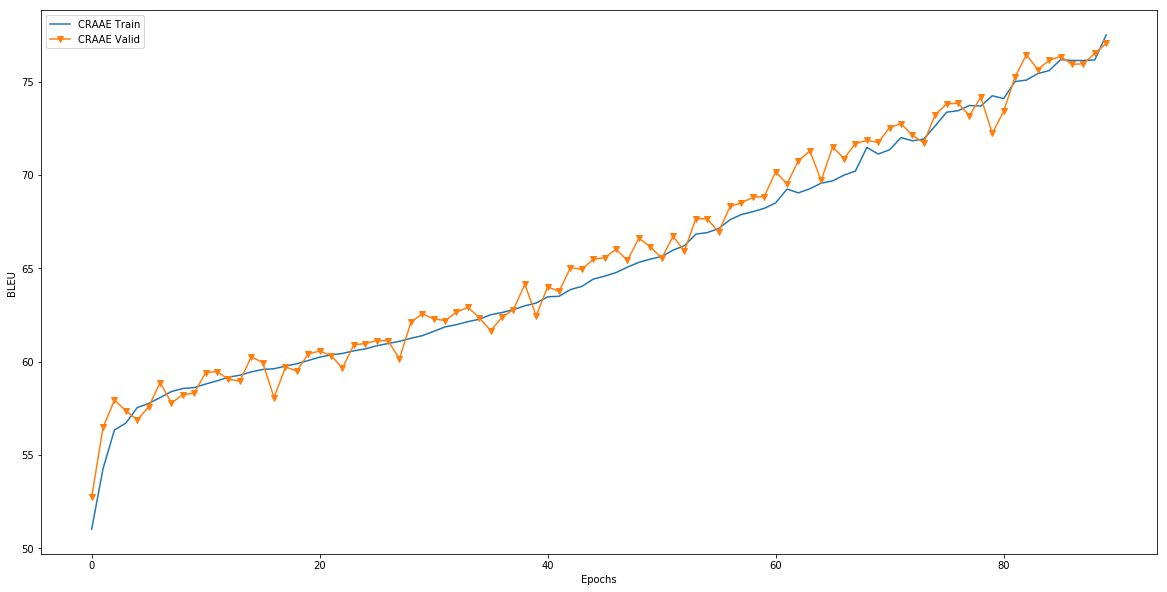

========== Start epoch 91 at 04:10:12 ==========
Epoch  91 Train: BLEU: 77.33, AE: 0.55808, G: 19.01495, ZD: 0.72945, SeqD: 0.00000  at 04:15:35
Epoch  91 Valid: BLEU: 76.66, AE: 0.82312, G: 19.33473, ZD: 0.69441, SeqD: 0.00000  at 04:15:41

Origin:  ['a man sitting in a chair in front of a red building . <eos>']
Decoded: ['a man sitting in a chair in front of a red building . <eos>']


Random sample:
	decoded w. style M: ['a child and an orange swimming in white running in a basketball game . <eos>']
	decoded w. style E: ['this is , my ice wrapped in a field play in the game <eos>']

========== Start epoch 92 at 04:15:41 ==========
Epoch  92 Train: BLEU: 77.11, AE: 0.56804, G: 19.03038, ZD: 0.73522, SeqD: 0.00000  at 04:21:03
Epoch  92 Valid: BLEU: 76.82, AE: 0.80359, G: 19.18533, ZD: 0.76498, SeqD: 0.00000  at 04:21:09

Origin:  ['a woman sites with her feet on the seats in a subway car . <eos>']
Decoded: ['a woman pulls a magazine car standing against a wooden and water behind him .

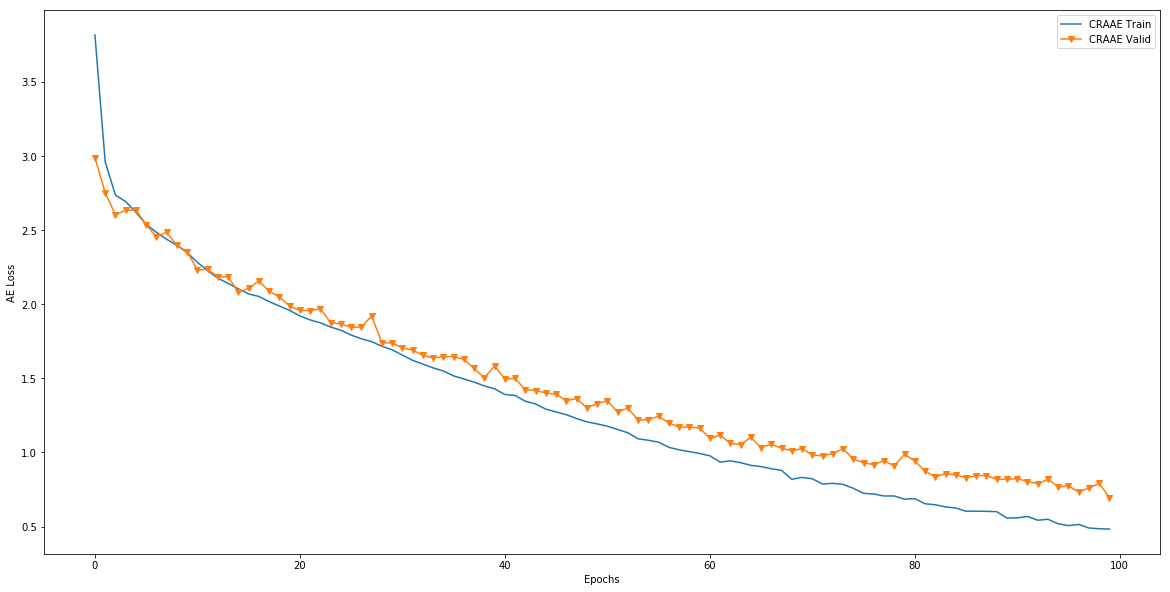

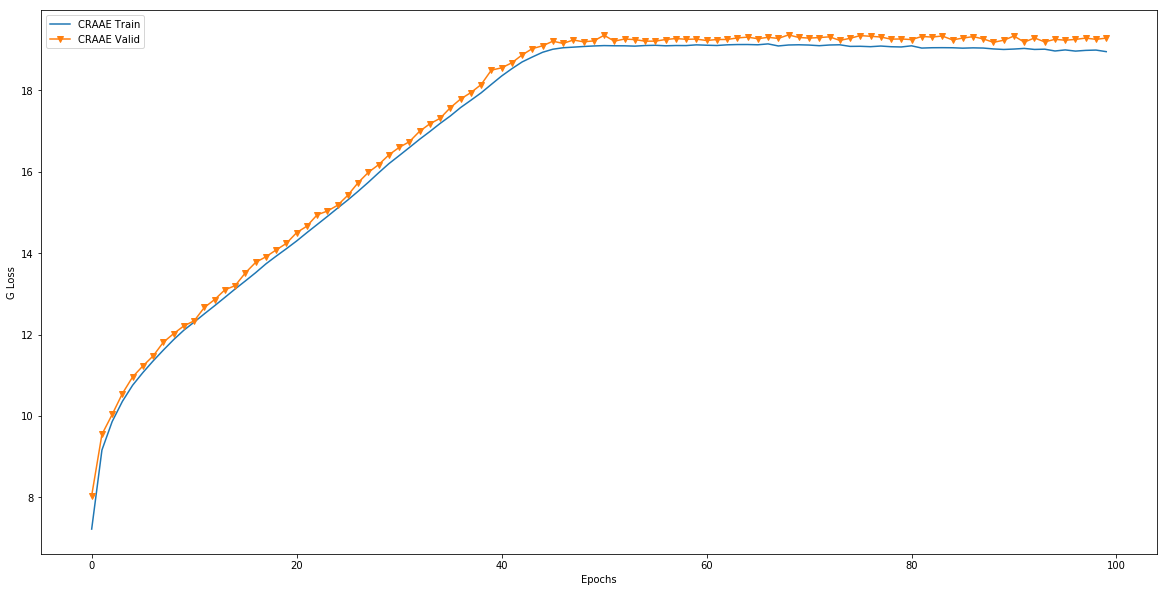

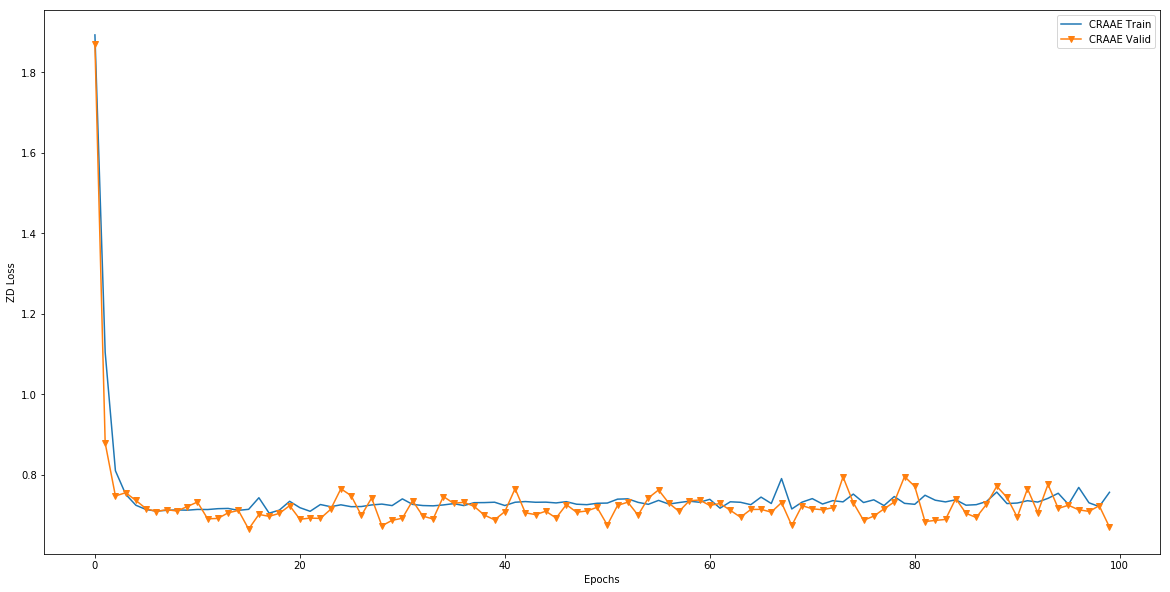

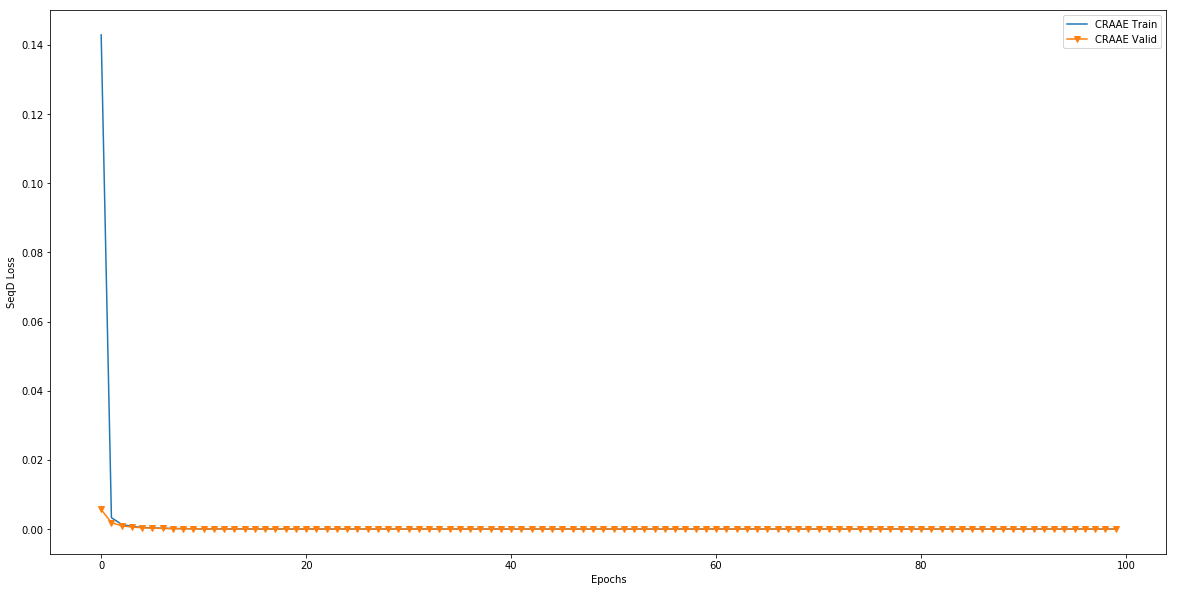

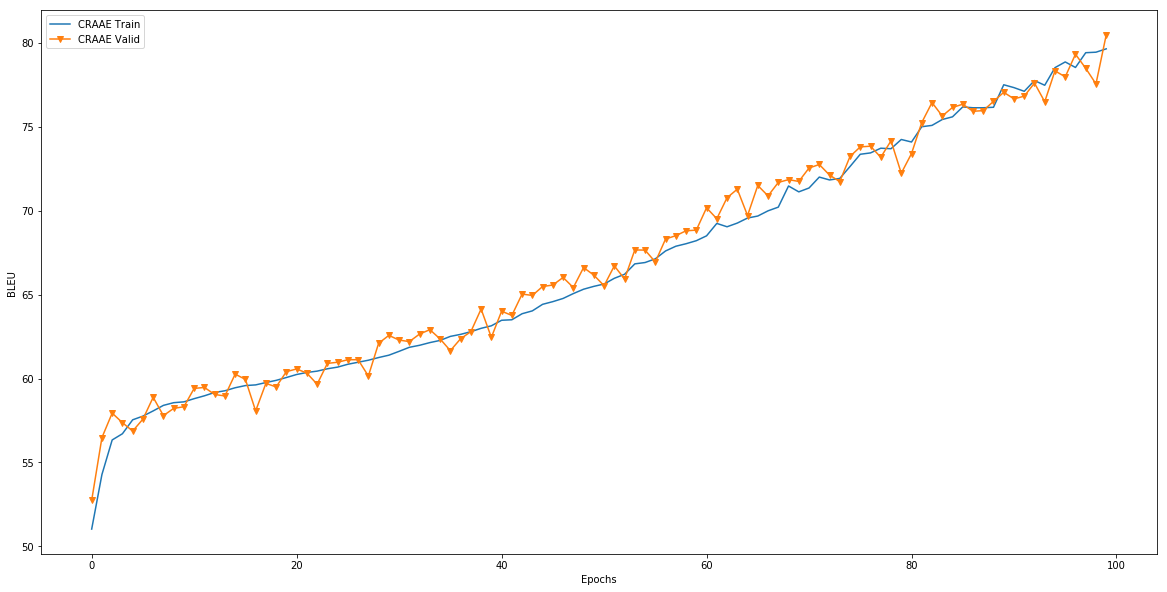

========== Start epoch 101 at 05:04:50 ==========
Epoch 101 Train: BLEU: 80.32, AE: 0.45824, G: 18.95004, ZD: 0.73526, SeqD: 0.00000  at 05:10:11
Epoch 101 Valid: BLEU: 79.11, AE: 0.73316, G: 19.18780, ZD: 0.73895, SeqD: 0.00000  at 05:10:17

Origin:  ['two martial artists are competing against one another on the mat while in the background people record this and take pictures . <eos>']
Decoded: ['two males knead a dance one foot , one of another player , a few people who is in the sidelines . <eos>']


Random sample:
	decoded w. style M: ["can i 'm lying , here s i make her for <eos>"]
	decoded w. style E: ["i still give up what actin ' i got to money <eos>"]

========== Start epoch 102 at 05:10:17 ==========
Epoch 102 Train: BLEU: 81.00, AE: 0.43995, G: 18.92617, ZD: 0.73929, SeqD: 0.00000  at 05:15:37
Epoch 102 Valid: BLEU: 79.75, AE: 0.72360, G: 19.20429, ZD: 0.72974, SeqD: 0.00000  at 05:15:43

Origin:  ['a whistle with whistle in his mouth carries a tray full of food up stairs . 

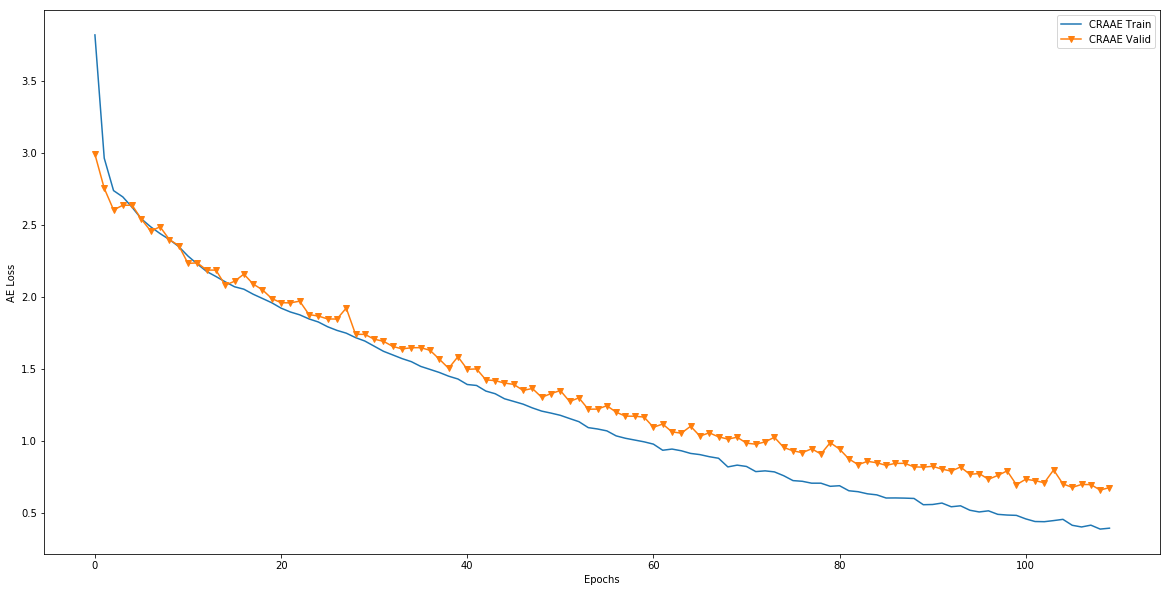

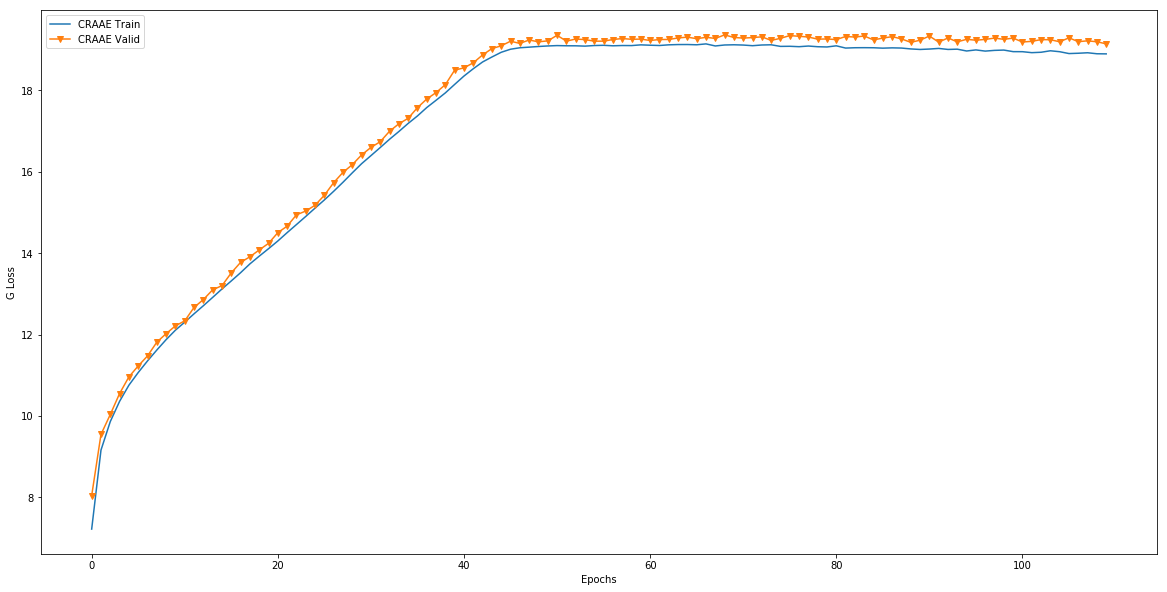

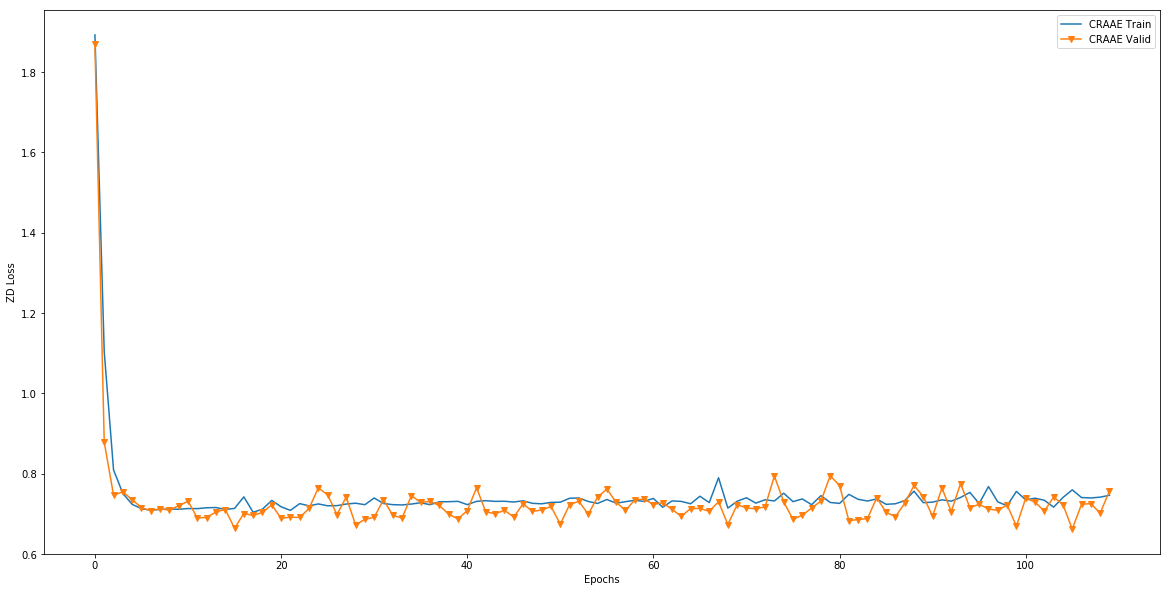

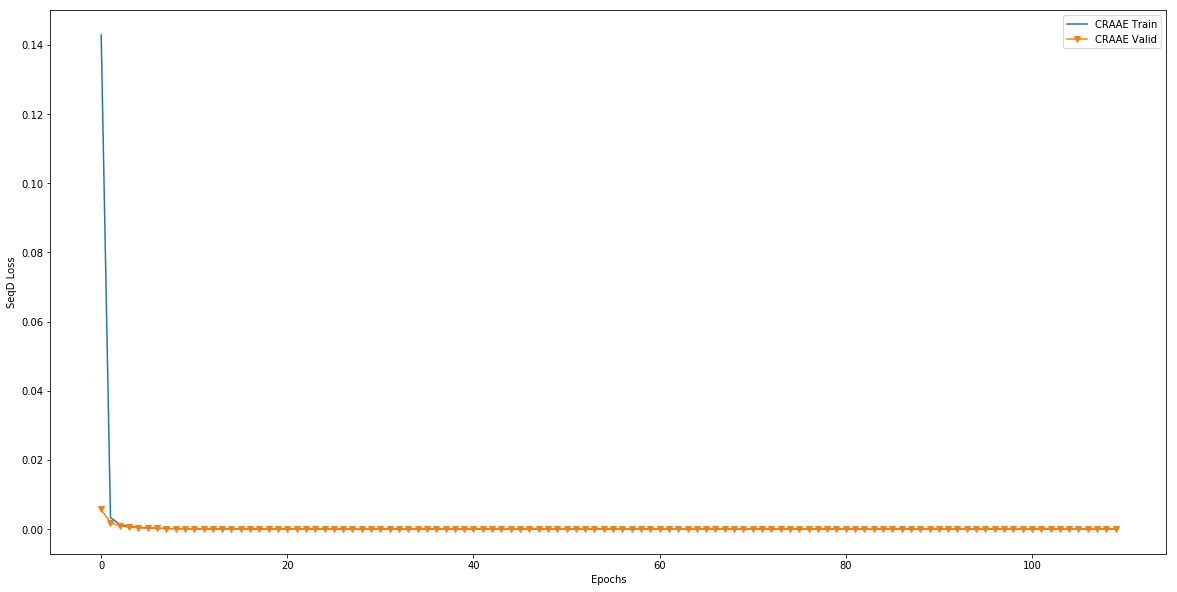

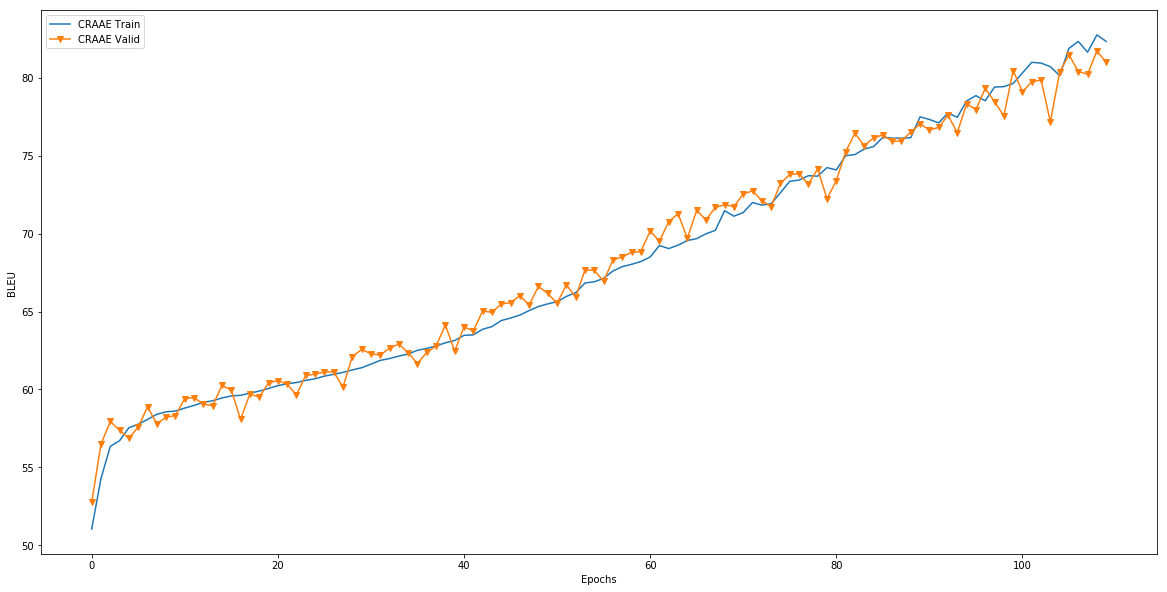

========== Start epoch 111 at 05:59:16 ==========
Epoch 111 Train: BLEU: 83.87, AE: 0.35800, G: 18.88279, ZD: 0.72642, SeqD: 0.00000  at 06:04:36
Epoch 111 Valid: BLEU: 81.60, AE: 0.66394, G: 19.16981, ZD: 0.72127, SeqD: 0.00000  at 06:04:42

Origin:  ['git out my face looking boy <eos>']
Decoded: ['blow the blunt i say play my']


Random sample:
	decoded w. style M: ['a person playing with red with graffiti in front . <eos>']
	decoded w. style E: ['a person and blue in yellow gear in a store . <eos>']

========== Start epoch 112 at 06:04:42 ==========
Epoch 112 Train: BLEU: 82.60, AE: 0.38583, G: 18.89440, ZD: 0.74576, SeqD: 0.00000  at 06:10:03
Epoch 112 Valid: BLEU: 79.40, AE: 0.72175, G: 19.17121, ZD: 0.76237, SeqD: 0.00000  at 06:10:09

Origin:  ["i 'm like that , catch a nigga like bear traps <eos>"]
Decoded: ["i 'm like that , for a hell and your head split"]


Random sample:
	decoded w. style M: ["see i do n't as someone , feel just kissed me . <eos>"]
	decoded w. style E: ["so

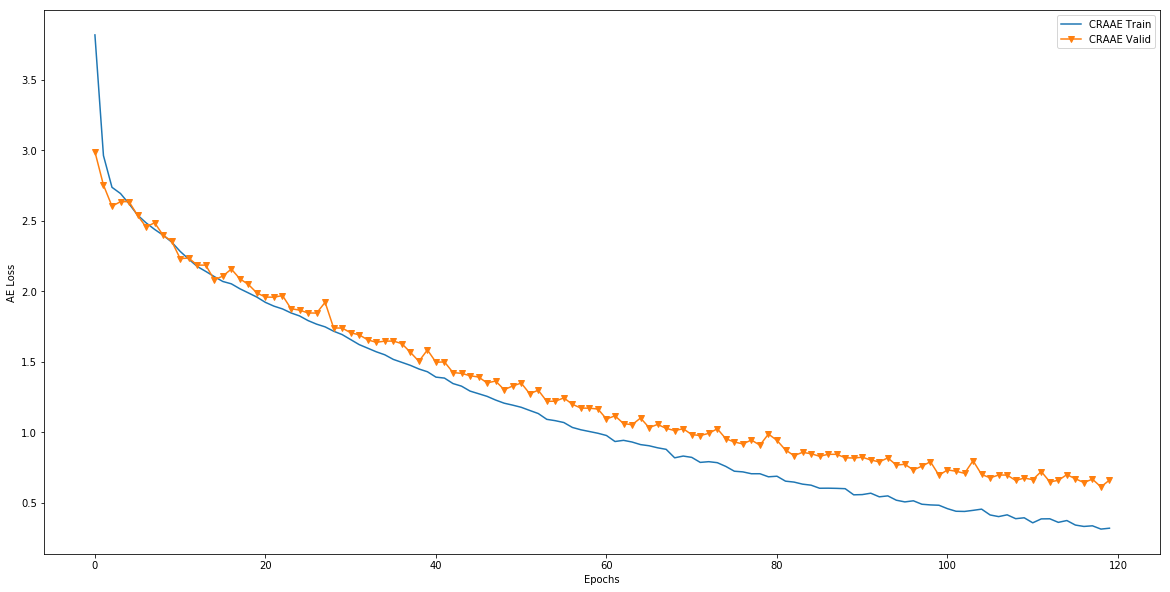

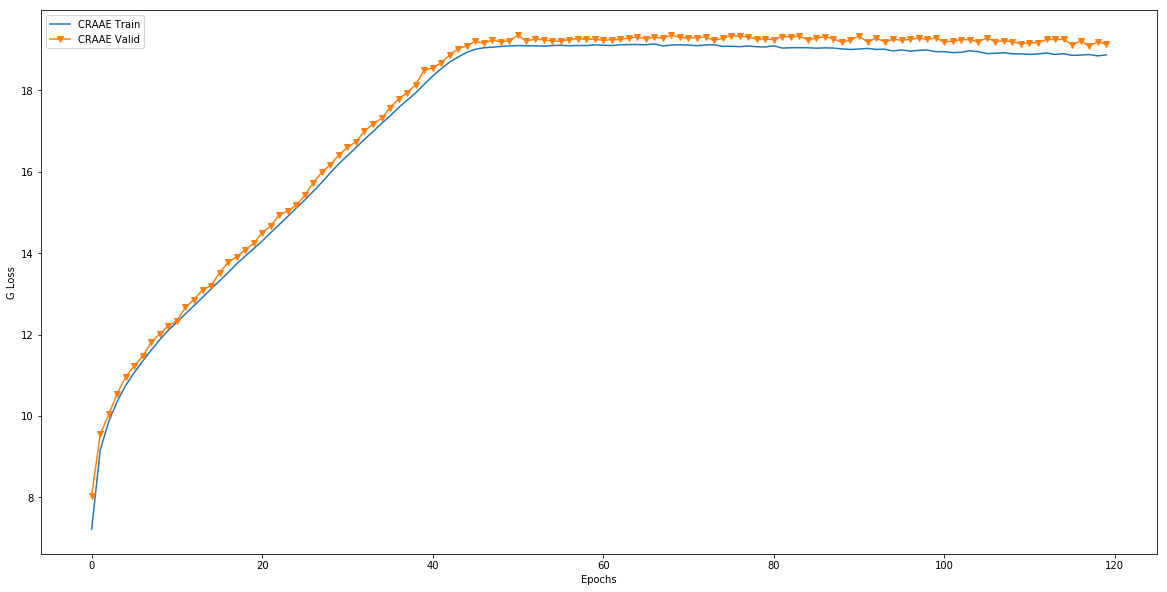

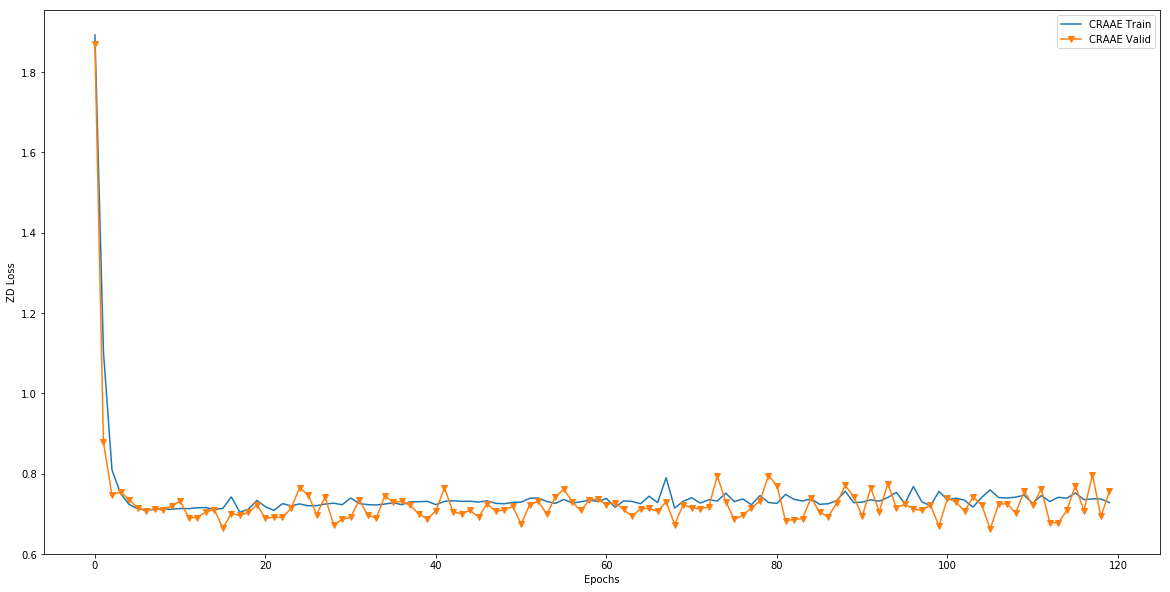

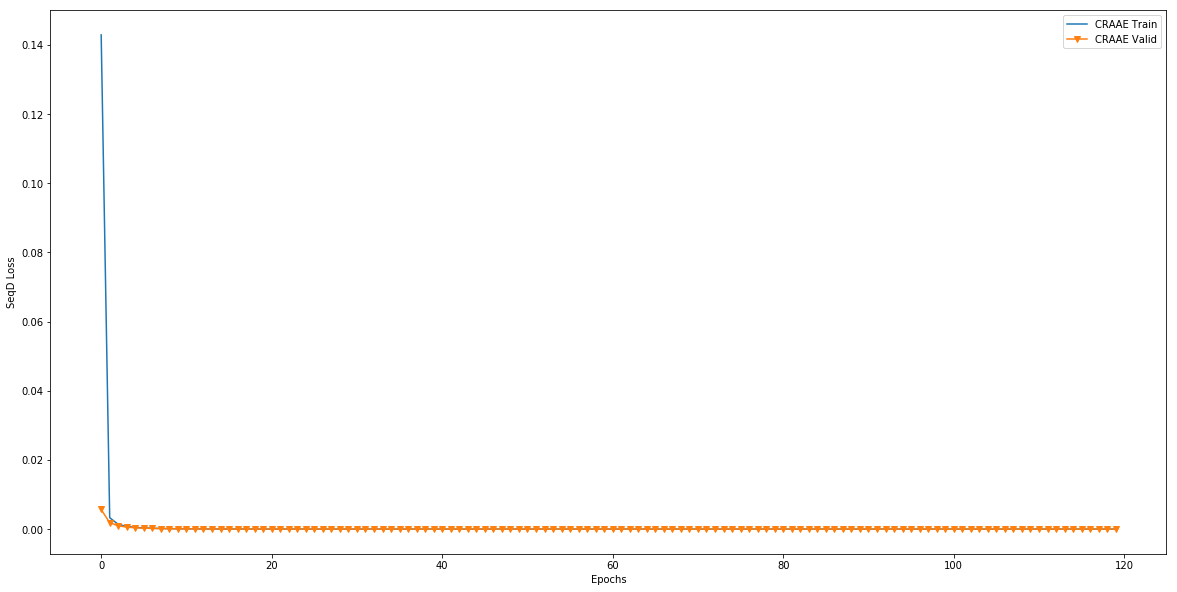

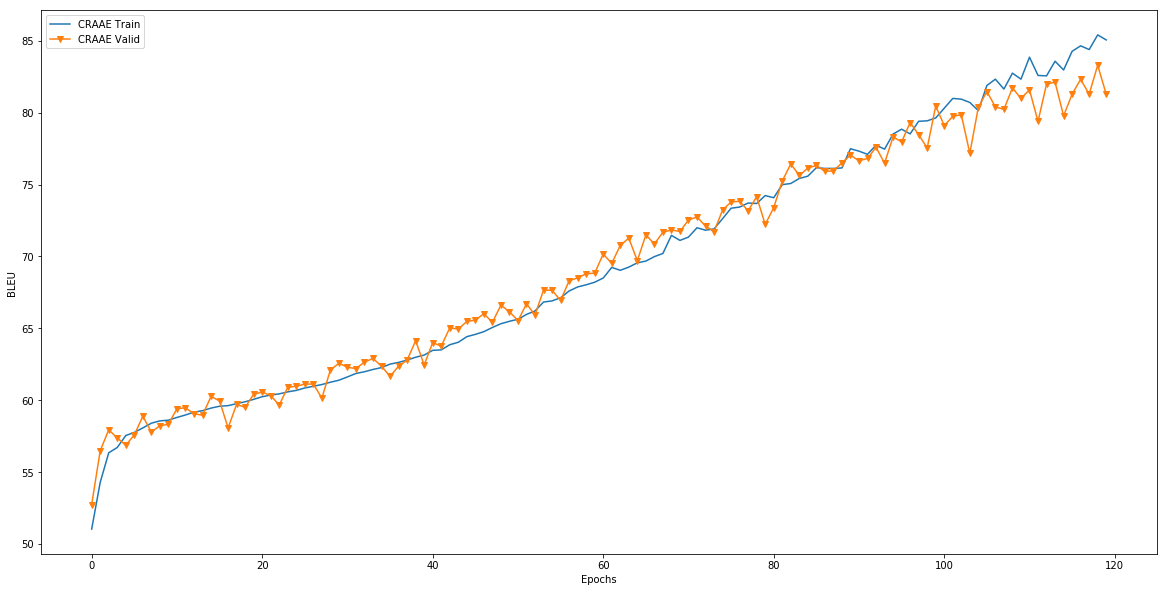

========== Start epoch 121 at 06:53:44 ==========
Epoch 121 Train: BLEU: 84.42, AE: 0.33258, G: 18.85371, ZD: 0.76121, SeqD: 0.00000  at 06:59:04
Epoch 121 Valid: BLEU: 82.55, AE: 0.63452, G: 19.13439, ZD: 0.75555, SeqD: 0.00000  at 06:59:10

Origin:  ['an older man sits on a bench at the bus stop . <eos>']
Decoded: ['an older man sits on a bench at the bus looking up .']


Random sample:
	decoded w. style M: ['3 asians with a parade protesting against a building <eos>']
	decoded w. style E: ['there participate with a parade to a pool <eos>']

========== Start epoch 122 at 06:59:10 ==========
Epoch 122 Train: BLEU: 86.63, AE: 0.28608, G: 18.84055, ZD: 0.72951, SeqD: 0.00000  at 07:04:31
Epoch 122 Valid: BLEU: 84.29, AE: 0.58202, G: 19.18625, ZD: 0.68935, SeqD: 0.00000  at 07:04:37

Origin:  ['a black and white dog jumping in a yard . <eos>']
Decoded: ['a black and white dog jumping in a yard . <eos>']


Random sample:
	decoded w. style M: ['just seen a public kuk looking sign with gent

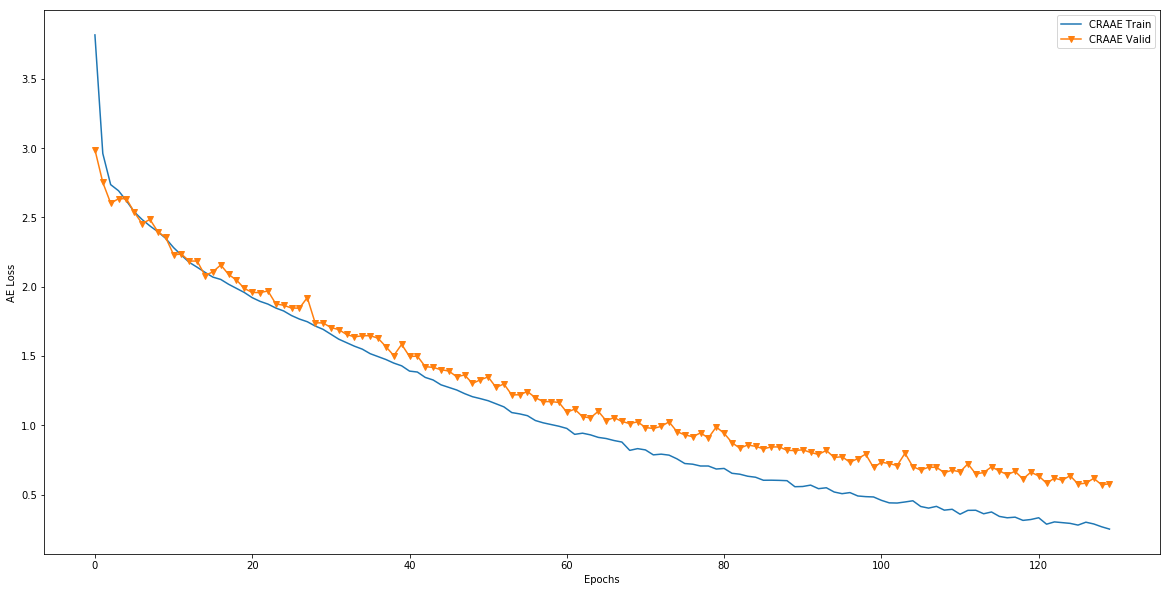

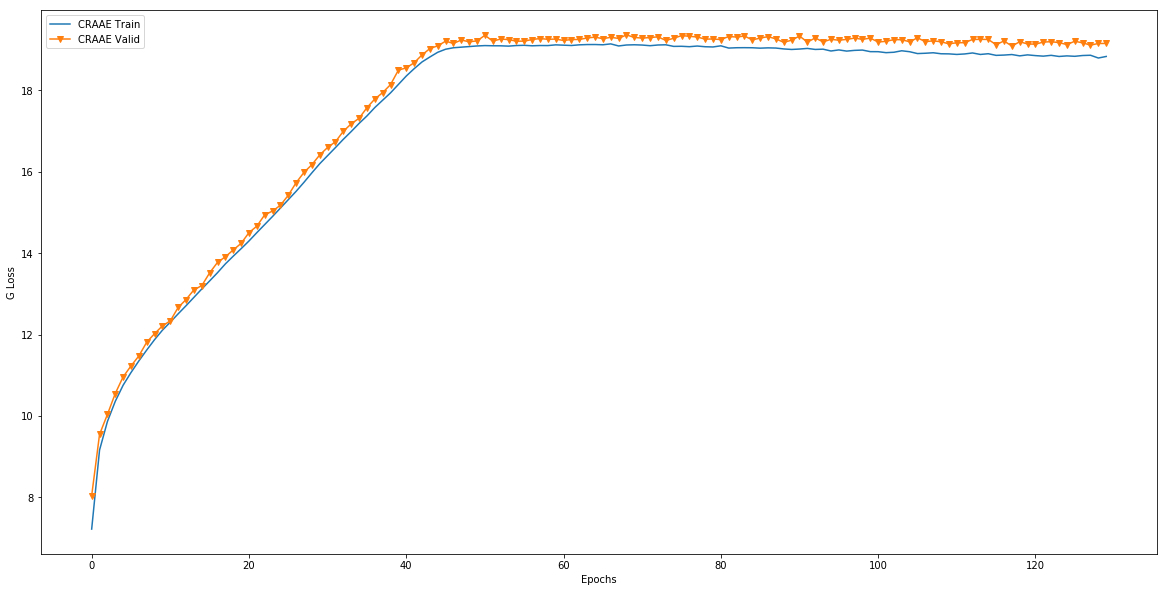

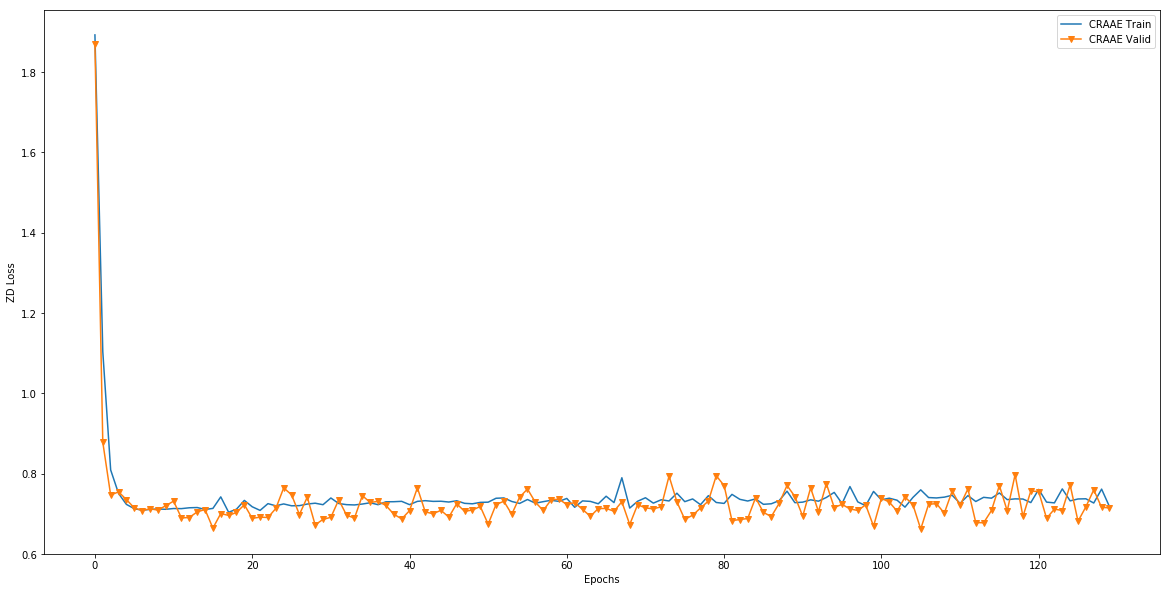

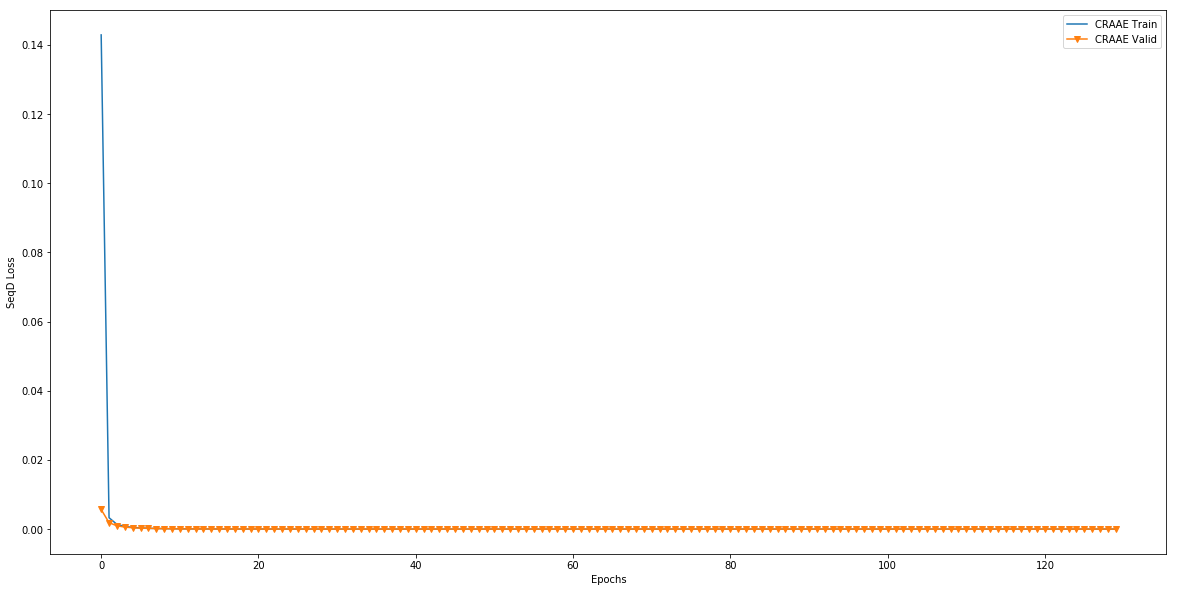

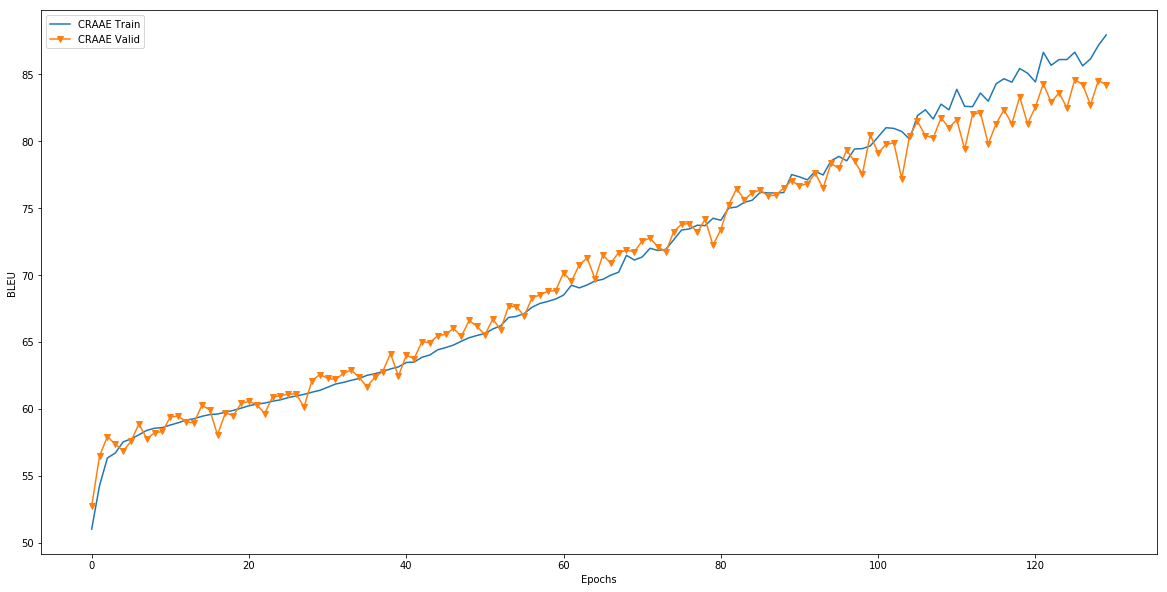

========== Start epoch 131 at 07:48:08 ==========
Epoch 131 Train: BLEU: 86.55, AE: 0.27631, G: 18.82745, ZD: 0.74823, SeqD: 0.00000  at 07:53:27
Epoch 131 Valid: BLEU: 81.69, AE: 0.64813, G: 18.96197, ZD: 0.93546, SeqD: 0.00000  at 07:53:34

Origin:  ["i ai n't causin ' nottin ' but problems <eos>"]
Decoded: ["i ai n't no for her at much , common"]


Random sample:
	decoded w. style M: ['an black dog near the equipment is into murky ground . <eos>']
	decoded w. style E: ['we black so a train all wrong <eos>']

========== Start epoch 132 at 07:53:34 ==========
Epoch 132 Train: BLEU: 88.03, AE: 0.24629, G: 18.81550, ZD: 0.73950, SeqD: 0.00000  at 07:58:53
Epoch 132 Valid: BLEU: 84.05, AE: 0.58625, G: 19.13768, ZD: 0.73762, SeqD: 0.00000  at 07:58:59

Origin:  ["this little antagonist fagot dick suckin ' <eos>"]
Decoded: ["this little antagonist fagot dick suckin ' dick"]


Random sample:
	decoded w. style M: ['two young men stand in a band and camouflage attire and are jumping . <eos>']

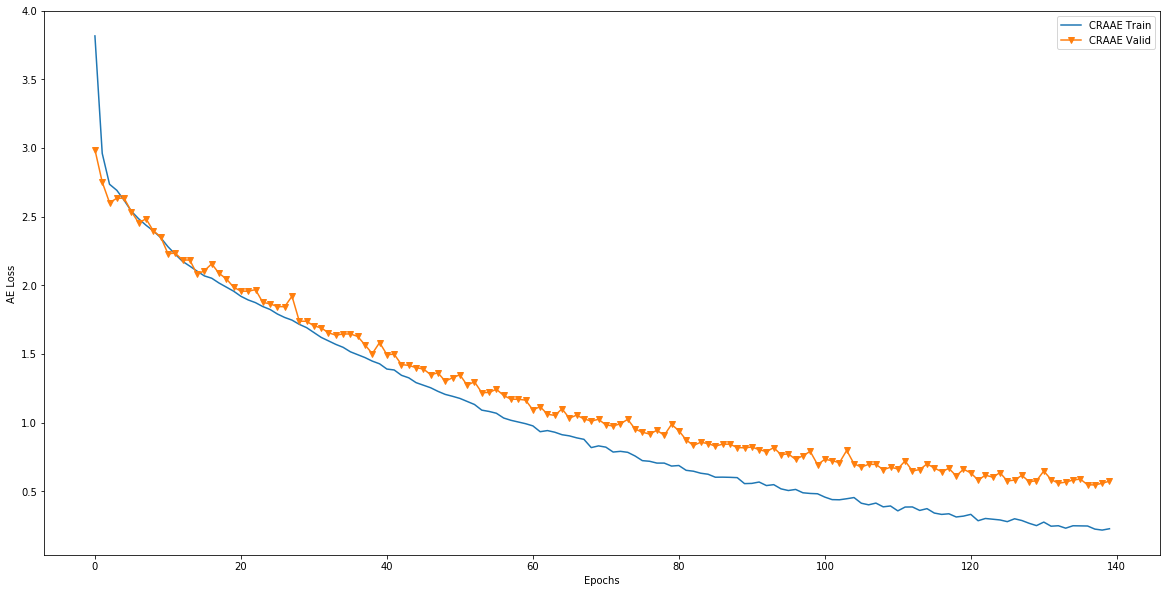

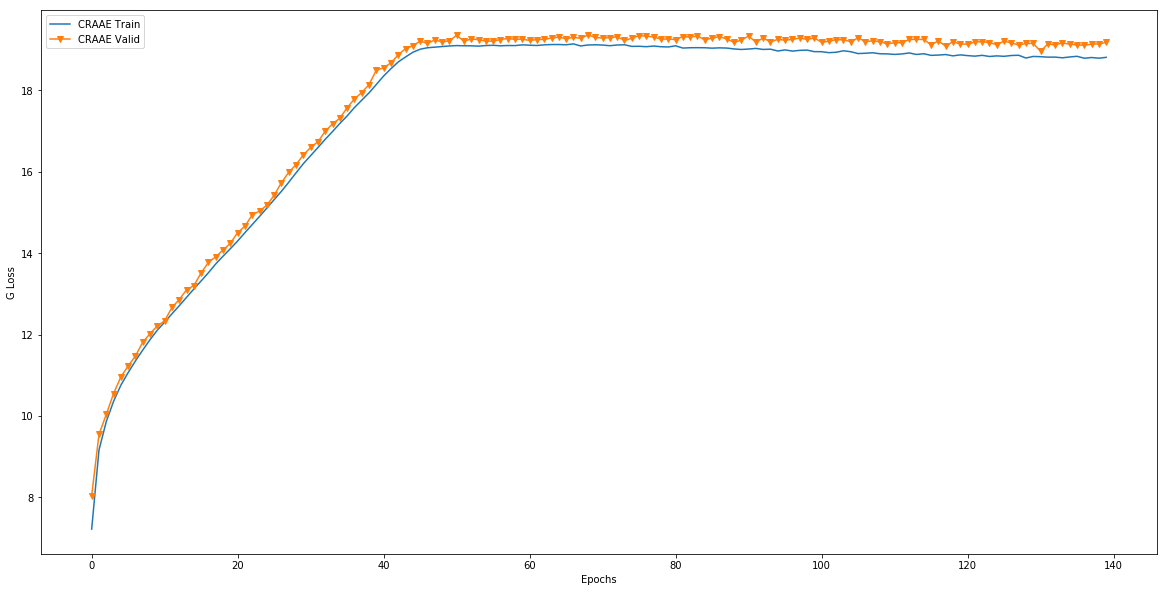

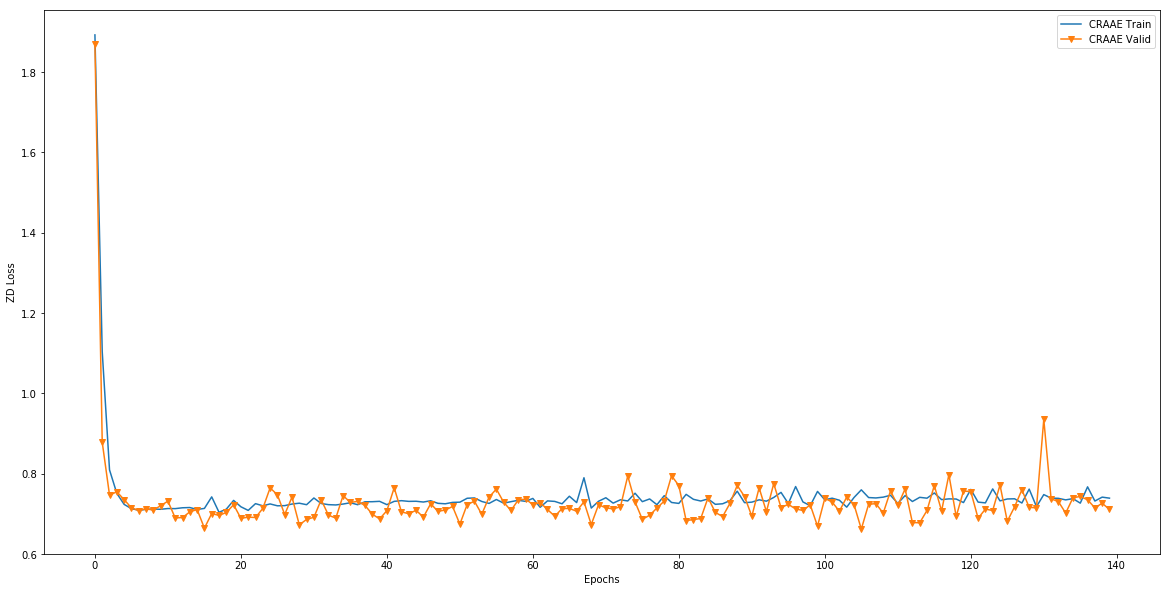

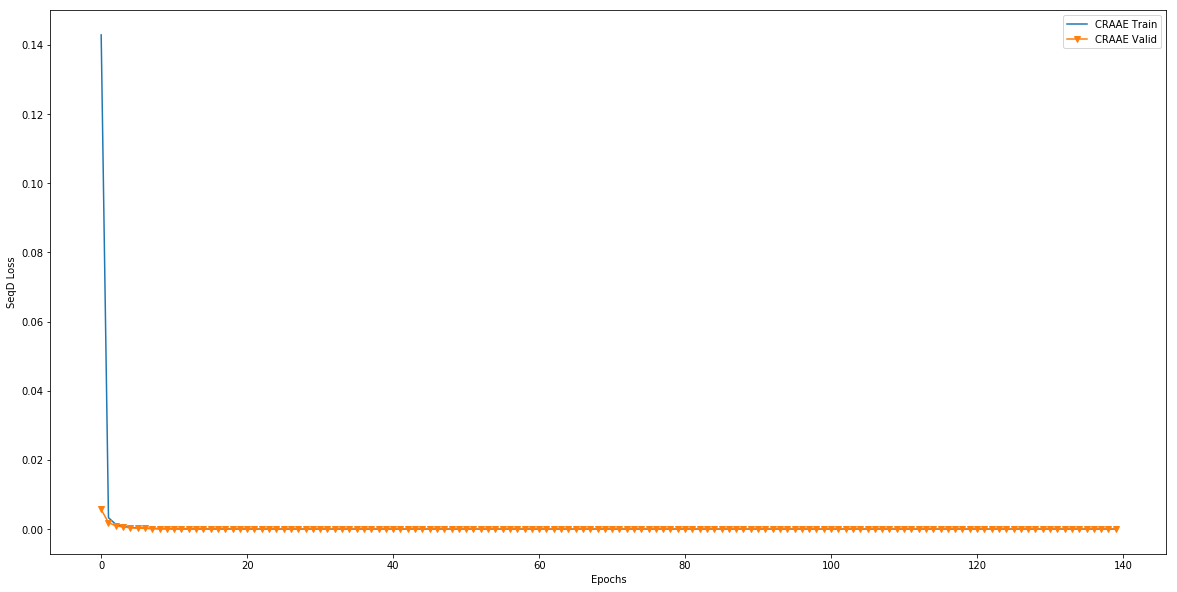

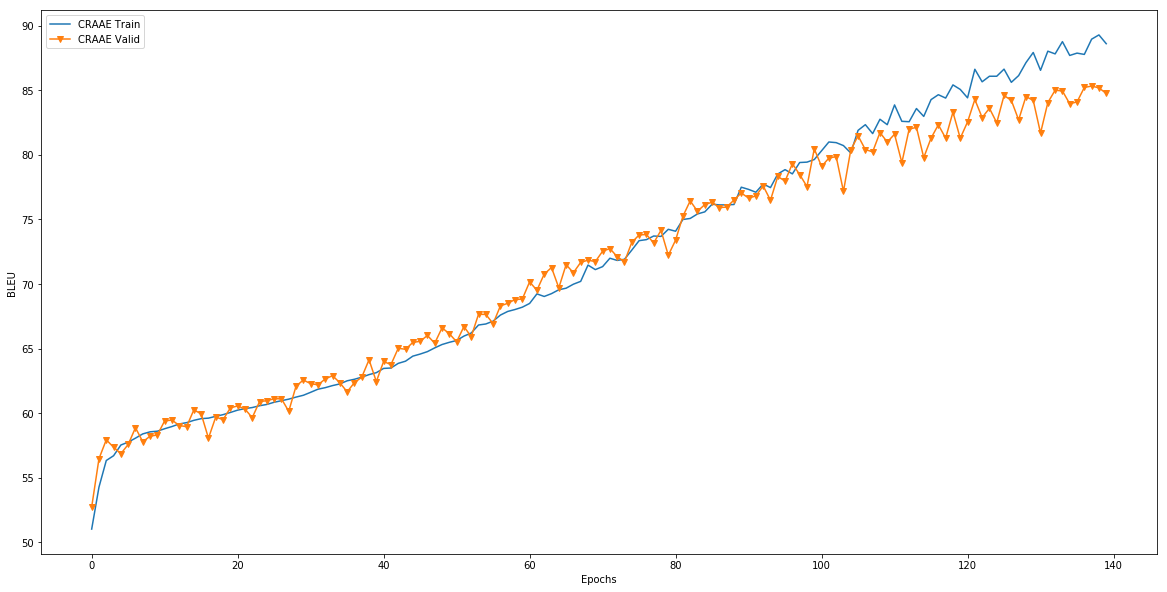

========== Start epoch 141 at 08:42:32 ==========
Epoch 141 Train: BLEU: 89.06, AE: 0.22035, G: 18.79157, ZD: 0.74942, SeqD: 0.00000  at 08:47:51
Epoch 141 Valid: BLEU: 85.47, AE: 0.54667, G: 19.07265, ZD: 0.76423, SeqD: 0.00000  at 08:47:57

Origin:  ['three people are standing in front of a blue wall with graffiti on it , while three metal poles and three green crates are in the foreground . <eos>']
Decoded: ['three people are standing in front of a blue wall with graffiti on it , while three burning poles and three men are walking on the stage . <eos>']


Random sample:
	decoded w. style M: ['one woman pulling a pink asian box carrying a skateboard of students . <eos>']
	decoded w. style E: ["hi the mean these song 's through people with <eos>"]

========== Start epoch 142 at 08:47:57 ==========
Epoch 142 Train: BLEU: 90.10, AE: 0.19999, G: 18.77597, ZD: 0.74340, SeqD: 0.00000  at 08:53:18
Epoch 142 Valid: BLEU: 85.27, AE: 0.55747, G: 19.13313, ZD: 0.73164, SeqD: 0.00000  at 08:53:2

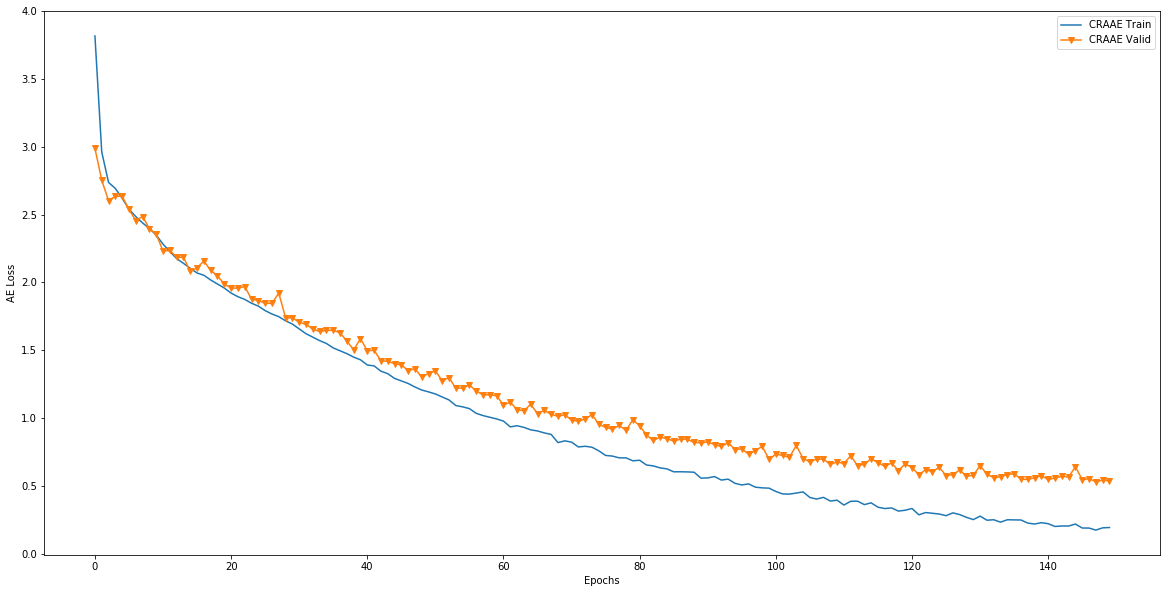

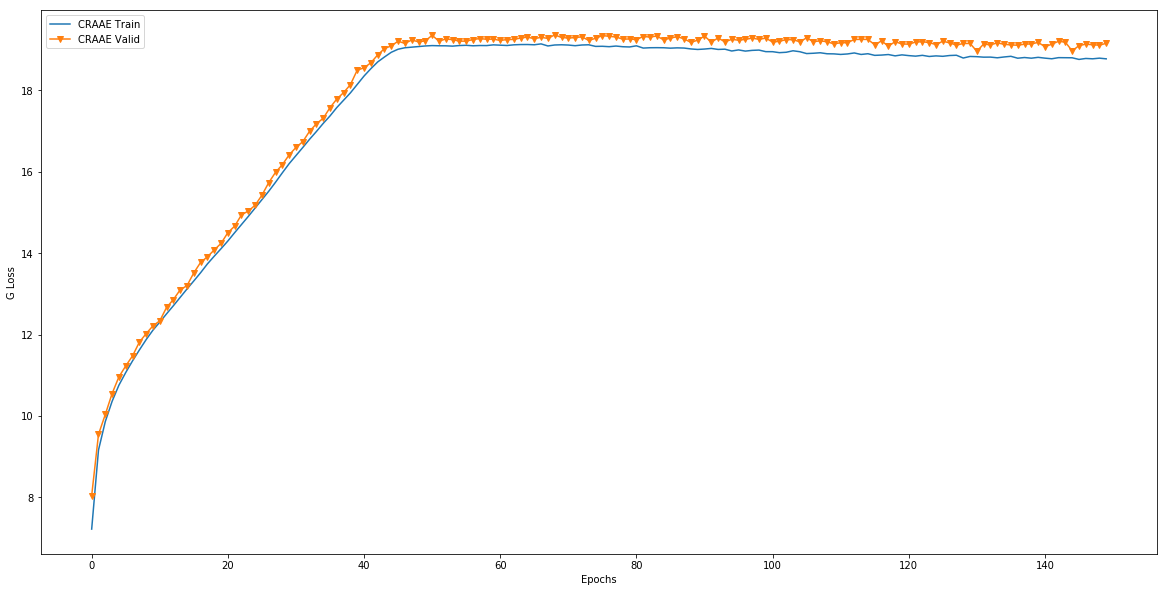

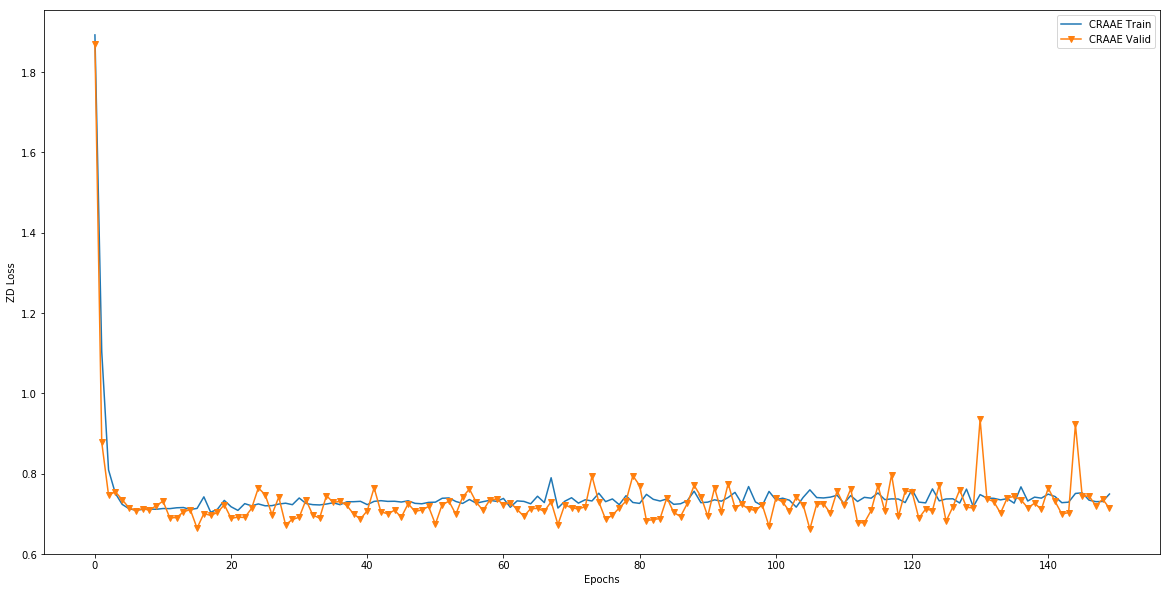

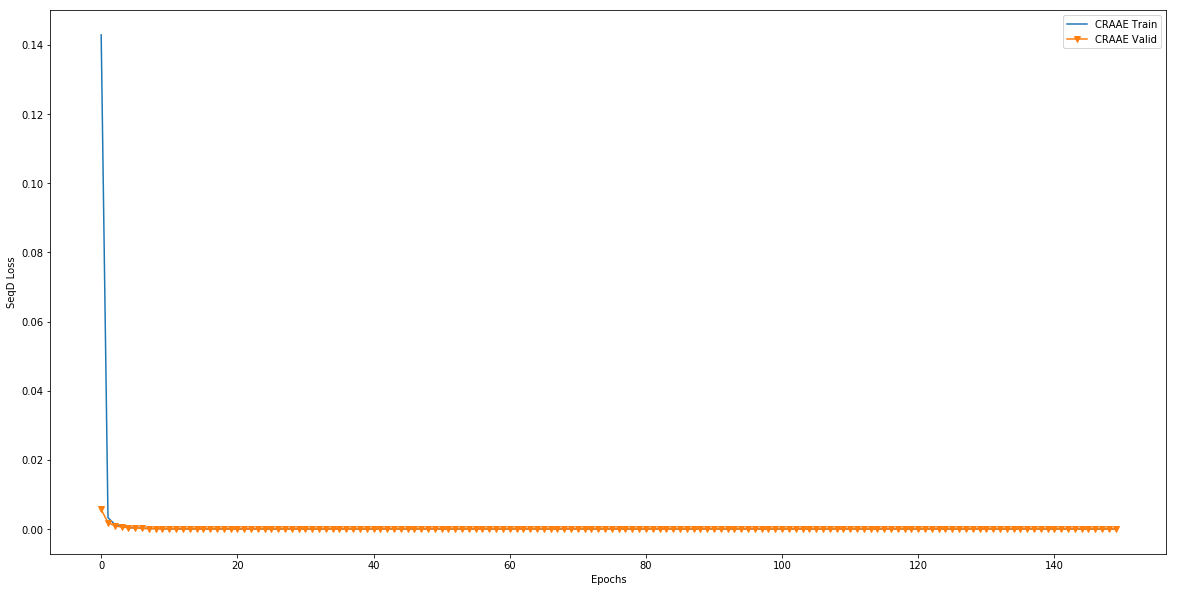

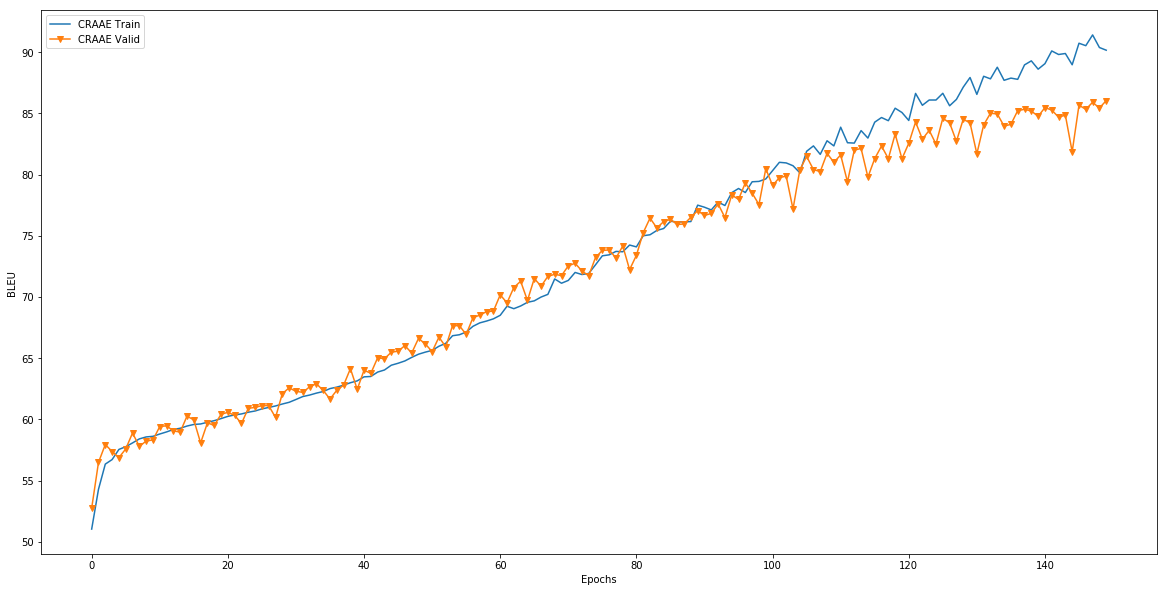

CPU times: user 11h 21min 25s, sys: 1h 41min 15s, total: 13h 2min 40s
Wall time: 13h 38min 5s


In [34]:
%%time

for epoch in range(1, 151):
    print("========== Start epoch {} at {} ==========".format(epoch, datetime.now().strftime("%H:%M:%S")))
    trn, val, _ = metrics['CRAAE']
    trn.append(train_raae(epoch, Enc, Dec, ZDisc, SeqDisc, prior_size, train_dl))
    val.append(validate_raae(epoch, Enc, Dec, ZDisc, SeqDisc, prior_size, valid_dl, 'Valid'))
    print_decoded(Enc, Dec, gen_dl)
    print_sample(Dec, sample_size=prior_size, max_seq_len=30)
            
    if epoch % 10 == 0: 
        torch.save(Enc.state_dict(), f'T2D-{hidden_size}H-3L.enc.e{epoch}.pt')
        torch.save(Dec.state_dict(), f'T2D-{hidden_size}H-3L.dec.e{epoch}.pt')
        torch.save(ZDisc.state_dict(), f'T2D-{hidden_size}H-3L.zdisc.e{epoch}.pt')
        torch.save(SeqDisc.state_dict(), f'T2D-{hidden_size}H-3L.seqdisc.e{epoch}.pt')
        plot_metrics(metrics, 0, 'AE Loss')
        plot_metrics(metrics, 1, 'G Loss')
        plot_metrics(metrics, 2, 'ZD Loss')
        plot_metrics(metrics, 3, 'SeqD Loss')
        plot_metrics(metrics, 4, 'BLEU')
        